# <span style="color:#ff1414"> BEDtools analysis. </span>

This is a script to answer research questions outlined elsewhere. In summary, this script:

1. compares methylation results between different methylation-callers, and between different methylation sequencing methods.

2. compares methylation between genes and non-gene regions

3. compares methylation between transposons and non-repetitive regions

4. compares transposons and genes


Note:
- PB/pb = PacBio
- ONT/ont = Oxford Nanopore Technology
- NP = Nanopolish

In [2]:
import pybedtools
import scipy

import matplotlib.patches as mpatches
import pandas as pd
import numpy as np # need for  stats

from scipy.stats import wilcoxon
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

In [3]:
# load modules
import os
import glob
import pprint
from pybedtools import BedTool
from scipy.stats import spearmanr

In [135]:

DIRS['TE_SF'] = os.path.join(DIRS['COVERAGE'], 'superfamily_files')
DIRS['RNA'] = os.path.join(DIRS['BASE2'], 'rna_counts')
DIRS['edgeR'] = os.path.join(DIRS['RNA'], 'edgeR_output')
DIRS['TRIALS'] = os.path.join(DIRS['RNA'], 'trials_tsv')
DIRS['MEAN_STD'] = os.path.join(DIRS['RNA'], 'average_and_stdev')
DIRS['GENE'] = os.path.join(DIRS['COVERAGE'], 'gene_level')
DIRS['GENE_ANNO'] = os.path.join(DIRS['GENE'], 'gene_anno')
DIRS['BOTH_U_D'] = os.path.join(DIRS['GENE'], 'both_upstream_downstream')
DIRS['DOWN_STR'] = os.path.join(DIRS['GENE'], 'downstream')
DIRS['UP_STR'] = os.path.join(DIRS['GENE'], 'upstream')
DIRS['TSS'] = os.path.join(DIRS['GENE'], 'tss_6mA_only')

In [7]:
DIRS['BASE1'] = '/home/anjuni/methylation_calling/pacbio'

DIRS['BED_INPUT'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'sequencing_comparison')
DIRS['GFF_INPUT'] = os.path.join(DIRS['BASE2'], 'gff_output')
DIRS['FIGURES'] = os.path.join(DIRS['BASE2'], 'figures')

DIRS['I_FROM_C'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'intersects_from_cutoffs')
DIRS['BED_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs')
DIRS['6MA_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_6mA')
DIRS['5MC_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_5mC')

In [6]:
#First we need to define the base dirs
DIRS = {}
DIRS['BASE2'] = '/home/anjuni/analysis'
DIRS['FEATURES'] = os.path.join(DIRS['BASE2'], 'coverage', 'feature_files')
DIRS['RAND'] = os.path.join(DIRS['BASE2'], 'coverage', 'randomisation')
DIRS['WINDOW_OUTPUT'] = os.path.join(DIRS['BASE2'], 'windows')
DIRS['WINDOW_INPUT'] = os.path.join(DIRS['BASE2'], 'input_for_windows')
DIRS['REF'] = '/home/anjuni/Pst_104_v13_assembly/'
DIRS['COVERAGE'] = os.path.join(DIRS['BASE2'], 'coverage')

In [9]:
#Quick chech if directories exist
for value in DIRS.values():
    if not os.path.exists(value):
        print('%s does not exist' % value)

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs does not exist


In [79]:
#Make filepaths
bed_file_list = [fn for fn in glob.iglob('%s/*.bed' % DIRS['BED_INPUT'], recursive=True)]
gff_file_list = [fn for fn in glob.iglob('%s/*anno.gff3' % DIRS['GFF_INPUT'], recursive=True)]
te_file_list = [fn for fn in glob.iglob('%s/*.gff' % DIRS['GFF_INPUT'], recursive=True)]

In [80]:
#Check that the list works
print(*bed_file_list, sep='\n')
print(*gff_file_list, sep='\n')
print(*te_file_list, sep='\n')

/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_tombo_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_np_tombo.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_hc_tombo_sorted.CpG.plus.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_s_nanopolish.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/nanopolish_rerun_subtract.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_hc_nanopolish_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_tombo_np.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/nano_plus_tombo_overlap.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_sorted.bed
/home/anjuni/analysis/bedtools_output/sequencing_comparison/5m

## <span style='color:deeppink'> 1. Comparing methylation sequencing methods <span/>

In [8]:
%%bash

# find overlap between 6mA from PacBio and Nanopore for 6mA data

pb=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed # use basecall accuracy instead of Phred score
ont=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed # use sites with non-zero methylation

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_pb_ont.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/6mA_ont_pb.bed

echo $pb
echo $ont

bedtools intersect -a $pb -b $ont > $out1
bedtools intersect -a $ont -b $pb > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed


In [9]:
# Function to count the number of sites in each file
def count_sites(file_list):
    """Outputs a dictionary of each cutoff file and the number of sites it has."""
    count_dict = {}
    for file in file_list:
        with open(file) as in_file:
            count = 0
            for line in in_file:
                count += 1
        count_dict[file.split('/')[-1]] = count
    return count_dict

In [81]:
#check how many overlapping sites there were
tech_overlap_dict = count_sites(bed_file_list)

In [82]:
tech_overlap_dict

{'5mC_CpG_np_tombo.bed': 3708640,
 '5mC_CpG_tombo_np.bed': 3708640,
 '5mC_hc_nanopolish_sorted.bed': 3783438,
 '5mC_hc_tombo_sorted.CpG.bed': 5167951,
 '5mC_hc_tombo_sorted.CpG.plus.bed': 5167951,
 '5mC_hc_tombo_sorted.bed': 67308386,
 '5mC_minus_tombo_sorted.bed': 34272921,
 '5mC_nanopolish_sorted.bed': 5302131,
 '5mC_np_tombo.bed': 1681653,
 '5mC_plus_CpG_np_tombo.bed': 3708640,
 '5mC_plus_CpG_tombo_np.bed': 3708640,
 '5mC_plus_tombo_sorted.bed': 34263097,
 '5mC_rerun_s_nanopolish.bed': 5302131,
 '5mC_s_nanopolish.bed': 5302131,
 '5mC_tombo_np.bed': 1681653,
 '5mC_tombo_sorted.bed': 68536018,
 '6mA_hc_tombo_sorted.bed': 83451878,
 '6mA_ont_pb.bed': 84733,
 '6mA_prob_smrtlink_sorted.bed': 88932,
 '6mA_tombo_sorted.bed': 85779879,
 'nano_minus_tombo_overlap.bed': 0,
 'nano_plus_tombo_overlap.bed': 5221309,
 'nanopolish_rerun_subtract.bed': 0}

In [27]:
#check how many overlapping sites there were
print('Total adenine sites:', '\t', tech_overlap_dict['6mA_tombo_sorted.bed'])
print('Nanopore 6mA sites:', '\t', tech_overlap_dict['6mA_hc_tombo_sorted.bed'])
print('PacBio 6mA sites:', '\t', tech_overlap_dict['6mA_prob_smrtlink_sorted.bed'])
print('Overlapping 6mA sites:', '\t', tech_overlap_dict['6mA_ont_pb.bed'])

Total adenine sites: 	 85779879
Nanopore 6mA sites: 	 83451878
PacBio 6mA sites: 	 88932
Overlapping 6mA sites: 	 84733


In [45]:
# Descriptive Statistics
print('Percentage overlap between PacBio and Nanopore as a proportion of PB sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['6mA_ont_pb.bed']/tech_overlap_dict['6mA_prob_smrtlink_sorted.bed']))
print('Percentage overlap between PacBio and Nanopore as a proportation of ONT sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['6mA_ont_pb.bed']/tech_overlap_dict['6mA_hc_tombo_sorted.bed']))
print('Percentage overlap between PacBio and Nanopore as a proportion of adenine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['6mA_ont_pb.bed']/tech_overlap_dict['6mA_tombo_sorted.bed']))
print('PacBio sites as a proportion of adenine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['6mA_prob_smrtlink_sorted.bed']/tech_overlap_dict['6mA_tombo_sorted.bed']))
print('Nanopore sites as a proportion of adenine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['6mA_hc_tombo_sorted.bed']/tech_overlap_dict['6mA_tombo_sorted.bed']))

Percentage overlap between PacBio and Nanopore as a proportion of PB sites: 	 95.278%
Percentage overlap between PacBio and Nanopore as a proportation of ONT sites: 	 0.102%
Percentage overlap between PacBio and Nanopore as a proportion of adenine: 	 0.099%
PacBio sites as a proportion of adenine: 	 0.104%
Nanopore sites as a proportion of adenine: 	 97.286%


#### <span style='color:deeppink'> Observations <span/>

Very high similarity between Nanopore and PacBio, when compared to PacBio. But PacBio sites are only a small fraction of Tombo sites, and only include highly accurate sites.

When overlapping PacBio and all Nanopore (Tombo) sites, which are all adenines in the genome, there was a higher overlap (88932) than when overlapping only non-zero PB and ONT sites (84733). This indicates PB detected sites that Nanopore did not, and these were high probability sites that were missed, as PB only had high probability (>99% basecall accuracy) sites.

There are also more overlapped sites when using the zero-probability sites from tombo, compared to only using only high confidence sites from both. This also suggests that Tombo/Nanopore had missed some methylated sites. In addition, Tombo is likely to have a high rate of false positives, as it detected 97% of adenines as methylated.

## <span style='color:#ff14ff'> 2. Comparing methylation detection methods <span/>

In [3]:
%%bash

# compare overlap between Tombo and Nanopolish for 5mC data
np=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_np_tombo.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_tombo_np.bed

echo $np
echo $tombo

bedtools intersect -a $np -b $tombo > $out1
bedtools intersect -a $tombo -b $np > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed


In [52]:
#check how many overlapping sites there were
print('Total cytosine sites:', '\t', tech_overlap_dict['5mC_tombo_sorted.bed'])
print('Total CpG sites:', '\t', tech_overlap_dict['5mC_nanopolish_sorted.bed'])
print('Tombo 5mC sites:', '\t', tech_overlap_dict['5mC_hc_tombo_sorted.bed'])
print('Nanopolish 5mC sites:', '\t', tech_overlap_dict['5mC_hc_nanopolish_sorted.bed'])
print('Overlapping 5mC sites:', '\t', tech_overlap_dict['5mC_tombo_np.bed'])

Total cytosine sites: 	 68536018
Total CpG sites: 	 5302131
Tombo 5mC sites: 	 67308386
Nanopolish 5mC sites: 	 3783438
Overlapping 5mC sites: 	 1681653


In [58]:
# Descriptive Statistics
print('Percentage overlap between Tombo and Nanopolish as a proportion of Nanopolish sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_tombo_np.bed']/tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']))
print('Percentage overlap between Tombo and Nanopolish as a proportation of Tombo sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_tombo_np.bed']/tech_overlap_dict['5mC_hc_tombo_sorted.bed']))
print('Percentage of overlap between Tombo and Nanopolish as a proportion of CpG sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_tombo_np.bed']/tech_overlap_dict['5mC_nanopolish_sorted.bed']))
print('Percentage overlap between Tombo and Nanopolish as a proportion of cytosine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_tombo_np.bed']/tech_overlap_dict['5mC_tombo_sorted.bed']))
print('Nanopolish sites as a proportion of CpG sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']/tech_overlap_dict['5mC_nanopolish_sorted.bed']))
print('Tombo sites as a proportion of cytosine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_hc_tombo_sorted.bed']/tech_overlap_dict['5mC_tombo_sorted.bed']))
print('Nanopolish sites as a proportion of cytosine:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']/tech_overlap_dict['5mC_tombo_sorted.bed']))

Percentage overlap between Tombo and Nanopolish as a proportion of Nanopolish sites: 	 44.448%
Percentage overlap between Tombo and Nanopolish as a proportation of Tombo sites: 	 2.498%
Percentage of overlap between Tombo and Nanopolish as a proportion of CpG sites: 	 31.717%
Percentage overlap between Tombo and Nanopolish as a proportion of cytosine: 	 2.454%
Nanopolish sites as a proportion of CpG sites: 	 71.357%
Tombo sites as a proportion of cytosine: 	 98.209%
Nanopolish sites as a proportion of cytosine: 	 5.520%


#### <span style='color:#ff14ff'> Observations <span/>
While adenine methylation had high similarity between ONT and PB, cytosine methylation had only 44% similarity between NP and tombo. This is likely because NP only has CpG sites, and Tombo has all cytosine sites, so Tombo will detect far more potentially methylated sites, even those that are not CpG sites, so it will have far more sites than NP to begin with.
Again, Tombo is likely to have a high amount of false positives, as 98% of cytosines are methylated. Nanopolish has 71% CpG methylation, which is similar to the CpG methylation rate in mammals, which is 70-80% (Jabbari & Bernardi, 2004). Therefore, Nanopolish is likely to be more accurate than Tombo.
The overlap between Tombo and Nanopolish suggests only a 2.5% rate of cytosine methylation, which is half the 5% cytosine methylation rate detected by Brar et al. (2018).

-source: https://www.sciencedirect.com/science/article/pii/S0378111904000836?via%3Dihub (Jabbari & Bernardi, 2004)

### <span style='color:#ff14ff'> 2.A Comparing CpG site methylation. <span/>

In [60]:
#check how many cytosine sites and CpG sites there are
print('CpG sites:', '\t', tech_overlap_dict['5mC_nanopolish_sorted.bed'])
print('Cytosine sites:', tech_overlap_dict['5mC_tombo_sorted.bed'])

CpG sites: 	 5302131
Cytosine sites: 68536018


In [61]:
# Descriptive Statistics
print('Percentage of CpG sites as a proportion of cytosine sites:', "{0:.3f}%".format(100*tech_overlap_dict['5mC_nanopolish_sorted.bed']/tech_overlap_dict['5mC_tombo_sorted.bed']))

Percentage of CpG sites as a proportion of cytosine sites: 7.736%


#### <span style='color:#ff14ff'> Solution <span/>
1. Make a file of methylated CpG sites detected by Tombo.
2. Intersect this with methylated (CpG) sites detected by Nanopolish.

I will be overlapping CpG sites from Tombo and NP, because NP only has CpG sites and Tombo has all cytosine sites.
So from the start, the overlap wouldn't have been accurate, because tombo considers sites that NP does not.

In [ ]:
%%bash

# make a file of CpG sites from tombo
all_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_nanopolish_sorted.bed
all_tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed
tombo_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed

bedtools intersect -a $all_tombo -b $all_cpg > $tombo_cpg

In [ ]:
%%bash

# intersect Tombo and NP CpG sites
tombo_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed
np_cpg=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
m_tombo_cpg=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_tombo_np.bed
m_np_cpg=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_CpG_np_tombo.bed

bedtools intersect -a $tombo_cpg -b $np_cpg > $m_tombo_cpg
bedtools intersect -a $np_cpg -b $tombo_cpg > $m_np_cpg

In [77]:
#check how many overlapping sites there were
print('Total CpG sites:', '\t', tech_overlap_dict['5mC_nanopolish_sorted.bed'])
print('Nanopolish methylated CpG sites:', '\t', tech_overlap_dict['5mC_hc_nanopolish_sorted.bed'])
print('Tombo methylated CpG sites:', '\t', tech_overlap_dict['5mC_hc_tombo_sorted.CpG.bed'])
print('Overlapping methylated CpG sites:', '\t', tech_overlap_dict['5mC_CpG_tombo_np.bed'])

Total CpG sites: 	 5302131
Nanopolish methylated CpG sites: 	 3783438
Tombo methylated CpG sites: 	 5167951
Overlapping methylated CpG sites: 	 3708640


In [369]:
%%bash

#check how many overlapping sites there were
cd /home/anjuni/analysis/bedtools_output/sequencing_comparison/

echo Nanopolish methylated CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed | wc -l

echo Tombo methylated CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed | wc -l

echo Overlapping methylated CpG sites:
less 5mC_CpG_tombo_np.bed | wc -l

echo Total CpG sites:
less /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_nanopolish_sorted.bed | wc -l

Nanopolish methylated CpG sites:
3783438
Tombo methylated CpG sites:
5167951
Overlapping methylated CpG sites:
3708640
Total CpG sites:
5302131


In [74]:
# Descriptive Statistics
print('Percentage overlap between Tombo and Nanopolish as a proportion of NP CpG sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_CpG_tombo_np.bed']/tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']))
print('Percentage overlap between Tombo and Nanopolish as a proportation of Tombo CpG sites:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_CpG_tombo_np.bed']/tech_overlap_dict['5mC_hc_tombo_sorted.CpG.bed']))
print('Percentage of overlapping CpG sites methylated:', '\t', "{0:.3f}%".format(100*tech_overlap_dict['5mC_CpG_tombo_np.bed']/tech_overlap_dict['5mC_nanopolish_sorted.bed']))

Percentage overlap between Tombo and Nanopolish as a proportion of NP CpG sites: 	 98.023%
Percentage overlap between Tombo and Nanopolish as a proportation of Tombo CpG sites: 	 71.762%
Percentage of CpG sites methylated: 	 69.946%


#### <span style='color:#ff14ff'> Observations <span/>
While the overlap between Tombo and NP changed to 98% after only comparing CpG sites, the nearly 50% overlap when comparing cytosine methylation may be because NP only considers one strand while Tombo considers both.
The Tombo cpG site was generated by intersecting Tombo methylated sites with all Nanopolish sites, which are all CpG sites.

This may be resolved by using only the plus file from Tombo and comparing its results to NP.

### <span style='color:#ff14ff'> 2.B Test out whether Nanopolish only detects (+) strand <span/>
Intersect tombo 5mC (-) strand file with nanopolish file to see if there is overlap. Then intersect the tombo (+) strand with nanopolish.

The 44% match may just be because I, for some reason, put all the nanopolish sites as (+) strand when making the original BED file :P

In [147]:
%%bash

#Sort the initial tombo bed files, because they were not sorted and slowed down the intersection

tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/initial_bed_files/5mC_minus_tombo.bed
tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/initial_bed_files/5mC_plus_tombo.bed
nanopolish=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed

sort_tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_minus_tombo_sorted.bed
sort_tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_plus_tombo_sorted.bed

sortBed -i $tombo_minus > $sort_tombo_minus
sortBed -i $tombo_plus > $sort_tombo_plus

In [148]:
%%bash

#Intersect the (+) and (-) BED files with nanopolish file
#to see whether Nanopolish has methylation-calls on both strands :)

sort_tombo_minus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_minus_tombo_sorted.bed
sort_tombo_plus=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_plus_tombo_sorted.bed
nanopolish=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed

intersectBed -a $nanopolish -b $sort_tombo_minus > /home/anjuni/methylation_calling/pacbio/input/bed_files/nano_minus_tombo_overlap.bed
intersectBed -a $nanopolish -b $sort_tombo_plus > /home/anjuni/methylation_calling/pacbio/input/bed_files/nano_plus_tombo_overlap.bed

In [85]:
#Compare the number of NP sites to Tombo sites on the forward and reverse strand

print('The number of CpG sites captured by Nanopolish:', '\t', tech_overlap_dict['5mC_nanopolish_sorted.bed'])
print('The number of overlapping (+) strand sites captured by Nanopolish and by Tombo:', '\t', tech_overlap_dict['nano_plus_tombo_overlap.bed'])
print('The number of overlapping (-) strand sites captured by Nanopolish and by Tombo:', '\t', tech_overlap_dict['nano_minus_tombo_overlap.bed'])

The number of CpG sites captured by Nanopolish: 	 5302131
The number of overlapping (+) strand sites captured by Nanopolish and by Tombo: 	 5221309
The number of overlapping (-) strand sites captured by Nanopolish and by Tombo: 	 0


In [83]:
print('Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites:', "{0:.3f}%".format(100*tech_overlap_dict['nano_plus_tombo_overlap.bed']/tech_overlap_dict['5mC_nanopolish_sorted.bed']))

Percentage overlap between Nanopolish and Tombo (forward strand) as a proportion of NP sites: 98.476%


There is a 98% similarity between Nanopolish sites and Tombo forward strand sites, but no similarity between Nanopolish sites and Tombo reverse strand sites, indicating that the 44% similarity between Nanopolish and Tombo from earlier was because Nanopolish only detected methylation on the forward strand.

I am currently re-running Nanopolish methylation-calling in case there was a mistake in the code earlier, causing it to ignore the reverse strand. Re-running the test run for pcontig_109 showed no difference in output to the previous one. They had the same number of sites (46801) and had the same output for the first 10 lines and last 10 lines. Now I think there wasn't a mistake because I only copied the index files to a new folder to save them back to the output folder, while a copy of all index files remained in the original fastq folder. This allowed methylation-calling to continue.

Based on these results, I will intersect the methylated forward strand CpG sites that Tombo detected with the the Nanopolish site, to ensure only related sites intersect :)

In [156]:
%%bash

#bedtools script to check nanopolish results
#if the subtract file is empty, the initial nanopolish run was accurate

nano1=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_s_nanopolish.bed
nano2=/home/anjuni/methylation_calling/pacbio/input/bed_files/5mC_rerun_s_nanopolish.bed
nano1_2_sub=/home/anjuni/methylation_calling/pacbio/input/bed_files/nanopolish_rerun_subtract.bed

bedtools subtract -a $nano1 -b $nano2 > $nano1_2_sub

In [86]:
print('Number of site differences between the original Nanopolish run and the re-run:', '\t', tech_overlap_dict['nanopolish_rerun_subtract.bed'])

Number of site differences between the original Nanopolish run and the re-run: 	 0


As there was no difference in sites between each Nanopolish run, the original run had no issues causing only the (+) strand to be detected and this issue is a result of the software.

### <span style='color:#ff14ff'> 2.C Finding overlap between forward strand CpG Sites. (Finally comparing methylation-callers.) <span/>

In [164]:
%%bash

#Make a tombo file with only forward strand CpG to match the Nanopolish data
grep '+' /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.bed > /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed

#This file ended up being exactly the same as the original CpG file for Tombo, but this new file will be used for added detail

In [165]:
%%bash


# compare overlap between Tombo and Nanopolish for forward strand CpG 5mC data
np=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
tombo=/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed

out1=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_np_tombo.bed
out2=/home/anjuni/analysis/bedtools_output/sequencing_comparison/5mC_plus_CpG_tombo_np.bed

echo $np
echo $tombo

bedtools intersect -a $np -b $tombo > $out1
bedtools intersect -a $tombo -b $np > $out2

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed


In [87]:
#Compare the number of (+) strand CpG NP sites to (+) strand CpG Tombo sites on the forward strand
print('The number of methylated CpG sites captured by Nanopolish:', '\t', tech_overlap_dict['5mC_hc_nanopolish_sorted.bed'])
print('The number of methylated CpG sites captured by Tombo on the (+) strand:', '\t', tech_overlap_dict['5mC_hc_tombo_sorted.CpG.plus.bed'])
print('The number of overlapping methylated CpG sites captured by Nanopolish and Tombo on the (+) strand:', '\t', tech_overlap_dict['5mC_plus_CpG_tombo_np.bed'])

The number of methylated CpG sites captured by Nanopolish: 	 3783438
The number of methylated CpG sites captured by Tombo on the (+) strand: 	 5167951
The number of overlapping methylated CpG sites captured by Nanopolish and Tombo on the (+) strand: 	 3708640


In [88]:
print('Percentage overlap between Nanopolish and Tombo (+ strand) as a proportion of NP sites:', "{0:.3f}%".format(100*tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']/tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']))
print('Percentage overlap between Nanopolish and Tombo (+ strand) as a proportion of tombo sites:', "{0:.3f}%".format(100*tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']/tech_overlap_dict['5mC_hc_tombo_sorted.CpG.plus.bed']))

Percentage overlap between Nanopolish and Tombo (+ strand) as a proportion of NP sites: 98.023%
Percentage overlap between Nanopolish and Tombo (+ strand) as a proportion of tombo sites: 71.762%


There was a 98% overlap between Nanopolish and Tombo sites, as a proportion of Nanopolish sites, as this was the smaller dataset. Using the positive strand CpG sites increased the overlap from 44% to 98%.

In [1527]:
print(a,b,c)

1459311 74798 3708640


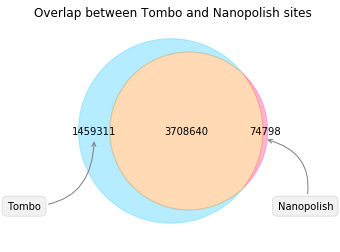

In [90]:
# First way to call the 2 group Venn diagram:
#The number of methylated CpG sites captured by Nanopolish:
#3783438
#The number of methylated CpG sites captured by Tombo on the forward strand:
#5167951
#The number of overlapping methylated CpG sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:
#3708640
c = tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
a = tech_overlap_dict['5mC_hc_tombo_sorted.CpG.plus.bed']-tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
b = tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']-tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
v = venn2(subsets = (a, b, c), set_labels = (' ', ' '))
v.get_patch_by_id('01').set_color('#ff47a3')
v.get_patch_by_id('10').set_color('#47d1ff')
v.get_patch_by_id('11').set_color('#ffa347')
plt.annotate('Tombo', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70), \
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1), \
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('Nanopolish', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(40,-70), \
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1), \
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.title('Overlap between Tombo and Nanopolish sites')
plt.show()

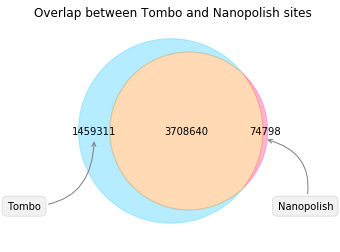

In [1531]:
# First way to call the 2 group Venn diagram:
#The number of methylated CpG sites captured by Nanopolish:
#3783438
#The number of methylated CpG sites captured by Tombo on the forward strand:
#5167951
#The number of overlapping methylated CpG sites captured by Nanopolish and by Tombo on the forward strand of the reference genome:
#3708640
c = tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
a = tech_overlap_dict['5mC_hc_tombo_sorted.CpG.plus.bed']-tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
b = tech_overlap_dict['5mC_hc_nanopolish_sorted.bed']-tech_overlap_dict['5mC_plus_CpG_tombo_np.bed']
v = venn2(subsets = (a, b, c), set_labels = (' ', ' '))
v.get_patch_by_id('01').set_color('#ff47a3')
v.get_patch_by_id('10').set_color('#47d1ff')
v.get_patch_by_id('11').set_color('#ffa347')
plt.annotate('Tombo', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70), \
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1), \
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('Nanopolish', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(40,-70), \
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1), \
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))

plt.title('Overlap between Tombo and Nanopolish sites')
plt.show()

In [ ]:
# Nanopore and PacBio Venn diagrams don't look good, since PacBio sites are 1% of Nanopore sites,
# so use the tombo nanopolish Venn diagram,
# and a table of percentages will be used

For the rest of the analysis, I will use the overlapped files for 5mC and 6mA data, and the Tombo files. This is because the Tombo files consider all possible A and C sites in the genome, and provide some consistency between the 6mA and 5mC data. In contrast, Nanopolish only detects 5mC at CpG sites on the forward strand, and SMRTLink does not provide a methylation-call accuracy value that is comparable to the accuracy in Nanopolis and Tombo. While Nanopolish and Tombo use the fraction of reads for the site that are methylated, SMRTLink uses a Phred score to determine methylation-call accuracy.

## <span style='color:#8a14ff'> 3. Making cutoff files. <span/>

### <span style='color:#8a14ff'> 3.A Making cutoff files from five original methylation-calling files, and intersect the two sequencing methods and the two methyaltion-callers. <span/>

In [1320]:
# Make the list of cutoffs
cutoff_list = [1.00, 0.99, 0.95, 0.90, 0.80, 0.70, 0.60, 0.50, 0.40, 0.30, 0.20, 0.10, 0.00]

In [ ]:
cutoff_list = sorted(cutoff_list)

In [497]:
len(cutoff_list)

13

In [196]:
# Define function to filter
def score_filter(feature, L):
    """Returns True if feature is longer than L"""
    return float(feature.score) >= L

def filter_by_cutoffs(bed_files, cutoffs, initial_file_path, final_file_path):
    """Filters files by the list of cutoffs given, and renames the file according to the cutoff."""
    for file in bed_files:
        pybed_object = BedTool(file)
        for x in cutoffs:
            filtered_file = pybed_object.filter(score_filter, x)
            cutoff = "{:.2f}".format(x)
            cutoff_name = '.cutoff.' + cutoff + '.bed'
            out_filename = file.replace('.bed', cutoff_name)
            out_filename = out_filename.replace(initial_file_path, final_file_path)
            filtered_file.saveas(out_filename)

In [ ]:
#Run the function to filter all files
initial_fp = '/home/anjuni/analysis/bedtools_output/sequencing_comparison/'
final_fp = '/home/anjuni/analysis/bedtools_output/cutoffs_from_intersects/'
filter_by_cutoffs(bed_file_list, cutoff_list, initial_fp, final_fp)

In [392]:
# make file handles for the four input files for intersecting, and the hc_tombo file for later analysis
sorted_bed_files = ['/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_nanopolish_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.CpG.plus.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/5mC_hc_tombo_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_prob_smrtlink_sorted.bed', \
                    '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/6mA_hc_tombo_sorted.bed']

In [ ]:
#Run the function to make cutoffs of all the sorted bed files
initial_fp1 = '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/'
final_fp1 = '/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs/'
filter_by_cutoffs(sorted_bed_files, cutoff_list, initial_fp1, final_fp1)

In [200]:
%%bash

#Move the 6mA files and 5mC files to separate folders, to make running intersections easier
cd /home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/
mkdir cutoffs_6mA
mkdir cutoffs_5mC
mv cutoffs/6mA* cutoffs_6mA
mv cutoffs/5mC* cutoffs_5mC
rmdir cutoffs

In [437]:
# make directories for 6mA and 5mC cutoff files
DIRS['BED_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs')
DIRS['6MA_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_6mA')
DIRS['5MC_CUTOFFS'] = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', 'cutoffs_5mC')

In [400]:
print(DIRS['BED_CUTOFFS'])
print(DIRS['6MA_CUTOFFS'])
print(DIRS['5MC_CUTOFFS'])

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC


In [504]:
# make a list of 6mA cutoff files from Nanopore and PacBio
ont_6mA = [fn for fn in glob.iglob('%s/6mA_hc_tombo*.bed' % DIRS['6MA_CUTOFFS'], recursive=True)]
pb_6mA = [fn for fn in glob.iglob('%s/6mA_prob_smrtlink*.bed' % DIRS['6MA_CUTOFFS'], recursive=True)]

#test out these lists by printing
print(*ont_6mA, sep='\n')
print(*pb_6mA, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.90.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.30.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.80.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.70.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.99.bed
/

In [505]:
# make a list of 5mC cutoff files from Nanopolish and Tombo
np_5mC = [fn for fn in glob.iglob('%s/5mC_hc_nanopolish*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]
tombo_CpG_5mC = [fn for fn in glob.iglob('%s/5mC_hc_tombo_sorted.CpG.plus*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]
tombo_5mC = [fn for fn in glob.iglob('%s/5mC_hc_tombo_sorted.c*.bed' % DIRS['5MC_CUTOFFS'], recursive=True)]

#test out these lists by printing
print(*np_5mC, sep='\n')
print(*tombo_CpG_5mC, sep='\n')
print(*tombo_5mC, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.90.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.00.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.80.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.50.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_nanopolish_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5

In [506]:
# the lists are not sorted, so sort them before doing cutoffs
ont_6mA = sorted(ont_6mA)
pb_6mA = sorted(pb_6mA)
np_5mC = sorted(np_5mC)
tombo_CpG_5mC = sorted(tombo_CpG_5mC)
tombo_5mC = sorted(tombo_5mC)

In [507]:
#Check if it worked. (It did!) :D
print(*ont_6mA, sep='\n')
print(*pb_6mA, sep='\n')
print(*np_5mC, sep='\n')
print(*tombo_CpG_5mC, sep='\n')
print(*tombo_5mC, sep='\n')

/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.00.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.10.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.20.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.30.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.40.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.50.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.60.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.70.bed
/home/anjuni/methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.0.80.bed
/

In [436]:
# make the filepaths for intersects output
DIRS['I_FROM_C'] = os.path.join(DIRS['BASE2'], 'bedtools_output', 'intersects_from_cutoffs')

In [494]:
# make a for loop to take a list of cutoffs, and a list of -a files and a list of -b files to intersect
def intersect_cutoffs(list_a, list_b, n_cutoffs, mod, a_name, b_name):
    """Take a list of files and intersect them with another list of files, where files are matched by methylation cutoff. Other required inputs are the number of cutoffs in the list, the modification, and the names to be used in the outfile to signify the BED file from list a and b."""
    for i in range(n_cutoffs): # go through each element in the sorted list, pairing them up
        a_bed = BedTool(list_a[i])
        b_bed = BedTool(list_b[i])
        cutoff_suffix = list_a[i][-16:] # get cutoff value from one of the files
        out_name = mod + '_' + a_name + '_' + b_name + cutoff_suffix # make a new file name with the two intersected files, basemod type and cutoff
        out_file = os.path.join(DIRS['I_FROM_C'], out_name) # make the file path
        intersected_cutoff = a_bed.intersect(b_bed).saveas(out_file) # save out the intersected file

In [ ]:
# Run intersect cutoffs for 6mA and 5mC
intersect_cutoffs(ont_6mA, pb_6mA, 13, '6mA', 'tombo', 'smrtlink')
intersect_cutoffs(tombo_CpG_5mC, np_5mC, 13, '5mC', 'tombo', 'nanopolish')

In [ ]:
%%bash

# Make one directory that contains cutoffs of all 4 bed files for use in downstream analysis
cd /home/anjuni/analysis/coverage
mkdir feature_files
cp ../bedtools_output/intersects_from_cutoffs/* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_5mC/5mC_hc_tombo_sorted.cutoff.* feature_files
cp ../../methylation_calling/pacbio/input/sorted_bed_files/cutoffs_6mA/6mA_hc_tombo_sorted.cutoff.* feature_files

In [508]:
# Make lists of cutoffs from each of the BED files for use in analysis in the new folder
# Remake the lists for the old ones under new names

# set filepaths for feature inputs
DIRS['FEATURES'] = os.path.join(DIRS['BASE2'], 'coverage', 'feature_files')

intersected_5mC = [fn for fn in glob.iglob('%s/5mC_t*.bed' % DIRS['FEATURES'], recursive=True)]
intersected_6mA = [fn for fn in glob.iglob('%s/6mA_t*.bed' % DIRS['FEATURES'], recursive=True)]
hc_tombo_5mC = [fn for fn in glob.iglob('%s/5mC_h*.bed' % DIRS['FEATURES'], recursive=True)]
hc_tombo_6mA = [fn for fn in glob.iglob('%s/6mA_h*.bed' % DIRS['FEATURES'], recursive=True)]

In [509]:
# Print lists to check they worked
pprint.pprint(intersected_5mC)
pprint.pprint(intersected_6mA)
pprint.pprint(hc_tombo_5mC)
pprint.pprint(hc_tombo_6mA)

['/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.90.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.99.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.70.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.80.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.95.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tom

In [510]:
# These lists are not sorted, so sort them before doing windows
intersected_5mC.sort()
intersected_6mA.sort()
hc_tombo_5mC.sort()
hc_tombo_6mA.sort()

In [1276]:
# Print sorted lists to check they worked (they did! time for windows)
pprint.pprint(intersected_5mC)
pprint.pprint(intersected_6mA)
pprint.pprint(hc_tombo_5mC)
pprint.pprint(hc_tombo_6mA)

['/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.60.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.70.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.80.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.90.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.95.bed',
 '/home/anjuni/analysis/coverage/feature_files/5mC_tom

### <span style='color:#8a14ff'> 3.B Making a table for the cutoff files. <span/>

In [ ]:
# Gather the lists to be used as inputs
pprint.pprint(np_5mC)
pprint.pprint(tombo_CpG_5mC)
pprint.pprint(pb_6mA)
pprint.pprint(ont_6mA)
pprint.pprint(intersected_5mC)
pprint.pprint(intersected_6mA)

In [1328]:
# Write the function to count sites
def make_site_count_list(fn_list):
    """This is a function that returns a list of the number of lines in a file, when a list of files is given as input."""
    site_count_list = []
    for fn in fn_list:
        count = 0
        with open(fn, 'r') as infile:
            for line in infile:
                count += 1
        site_count_list.append(count)
    return site_count_list

In [1329]:
np_5mC_count_list = make_site_count_list(np_5mC)
tombo_CpG_5mC_count_list = make_site_count_list(tombo_CpG_5mC)
pb_6mA_count_list = make_site_count_list(pb_6mA)
ont_6mA_count_list = make_site_count_list(ont_6mA)
intersected_5mC_count_list = make_site_count_list(intersected_5mC)
intersected_6mA_count_list = make_site_count_list(intersected_6mA)

In [1331]:
print(np_5mC_count_list)
print(tombo_CpG_5mC_count_list)
print(pb_6mA_count_list)
print(ont_6mA_count_list)
print(intersected_5mC_count_list)
print(intersected_6mA_count_list)

[3783438, 2655129, 2408326, 2329892, 2287038, 2249995, 2195581, 2122684, 1995419, 1597784, 1068255, 609093, 608808]
[5167951, 5123192, 4970628, 4660551, 4184707, 3511671, 2414941, 1380931, 681458, 249792, 140848, 120970, 120970]
[88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 88932, 68]
[83451878, 80777279, 73301535, 61332775, 47837744, 34554267, 19402593, 8986431, 3668473, 1333195, 928352, 882625, 882625]
[3708640, 2581835, 2313616, 2174002, 2025031, 1823390, 1439138, 953767, 502953, 151839, 53649, 30708, 30691]
[84733, 77694, 66199, 53979, 42461, 31857, 19602, 10085, 4457, 1380, 622, 507, 0]


In [1379]:
# Make a list of percentage overlap
def make_percent_overlap_list(intersect_list, smaller_file_list):
    """Calculates percentage of intersection as a proportion of the smaller input file."""
    percent_list = []
    for i in range(len(intersect_list)):
        if intersect_list[i] == 0:
            percent = float(0)
            percent_list.append(percent)
        else:
            percent = intersect_list[i] / smaller_file_list[i]
            percent = 100*percent
            percent_list.append(percent)
    return percent_list

In [1380]:
percent_overlap_5mC = make_percent_overlap_list(intersected_5mC_count_list, np_5mC_count_list)
percent_overlap_6mA = make_percent_overlap_list(intersected_6mA_count_list, pb_6mA_count_list)

In [1367]:
cutoff_5mC = {}
cutoff_5mC['Tombo Sites'] = tombo_CpG_5mC_count_list
cutoff_5mC['Nanopolish Sites'] = np_5mC_count_list
cutoff_5mC['Overlapping Sites'] = intersected_5mC_count_list
cutoff_5mC['Methylated Fraction Cutoff'] = cutoff_list
cutoff_5mC['Percentage Overlap (%)'] = percent_overlap_5mC

In [1381]:
cutoff_6mA = {}
cutoff_6mA['PacBio Sites'] = pb_6mA_count_list
cutoff_6mA['Nanopore Sites'] = ont_6mA_count_list
cutoff_6mA['Overlapping Sites'] = intersected_6mA_count_list
cutoff_6mA['Methylated Fraction Cutoff'] = cutoff_list
cutoff_6mA['Percentage Overlap (%)'] = percent_overlap_6mA

In [1383]:
# Save the dataframes as csv files for 5mC and 6mA
df = pd.DataFrame.from_dict(cutoff_5mC)
df = df [['Methylated Fraction Cutoff', 'Tombo Sites', 'Nanopolish Sites', 'Overlapping Sites', 'Percentage Overlap (%)']]
df.to_csv(os.path.join(DIRS['FIGURES'], '5mC_cutoff_table'), header=True, index=None, sep='\t')

df = pd.DataFrame.from_dict(cutoff_6mA)
df = df [['Methylated Fraction Cutoff', 'Nanopore Sites', 'PacBio Sites', 'Overlapping Sites', 'Percentage Overlap (%)']]
df.to_csv(os.path.join(DIRS['FIGURES'], '6mA_cutoff_table'), header=True, index=None, sep='\t')

### <span style='color:#8a14ff'> 3.C Making random distributions of the same size as all the cutoff files. <span/>

In [533]:
# Inputs needed:

# file of all C in genome
all_c = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '5mC_tombo_sorted.bed')
# file of all A in genome
all_a = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '6mA_tombo_sorted.bed')
# file of all (+) strand CpG
all_cpg = os.path.join(DIRS['BASE1'], 'input', 'sorted_bed_files', '5mC_hc_tombo_sorted.CpG.plus.bed')

In [537]:
# Function to count the number of sites in each cutoff file
def count_sites(file_list):
    """Outputs a dictionary of each cutoff file and the number of sites it has."""
    count_dict = {}
    for file in file_list:
        with open(file) as in_file:
            count = 0
            for line in in_file:
                count += 1
        count_dict[file.split('/')[-1]] = count
    return count_dict

In [859]:
# Function to make the list of output randomisation file for each input cutoff file
def out_rand_files(file_list):
    """Outputs a dictionary of output randomisation file paths for a given list of input file paths."""
    rand_dict = {}
    for file in file_list:
        out_name = file.replace('.bed', '_rand.bed')
        out_name = out_name.replace('feature_files', 'randomisation')
        rand_dict[file.split('/')[-1]] = out_name
    return rand_dict

In [602]:
# Make count dictionaries separated by modification type
intersect_5mC_count_dict = count_sites(intersected_5mC)
intersect_6mA_count_dict = count_sites(intersected_6mA)
tombo_5mC_count_dict = count_sites(hc_tombo_5mC)
tombo_6mA_count_dict = count_sites(hc_tombo_6mA)

In [611]:
pprint.pprint(intersect_5mC_count_dict)
pprint.pprint(intersect_6mA_count_dict)
pprint.pprint(tombo_5mC_count_dict)
pprint.pprint(tombo_6mA_count_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': 3708640,
 '5mC_tombo_nanopolish.cutoff.0.10.bed': 2581835,
 '5mC_tombo_nanopolish.cutoff.0.20.bed': 2313616,
 '5mC_tombo_nanopolish.cutoff.0.30.bed': 2174002,
 '5mC_tombo_nanopolish.cutoff.0.40.bed': 2025031,
 '5mC_tombo_nanopolish.cutoff.0.50.bed': 1823390,
 '5mC_tombo_nanopolish.cutoff.0.60.bed': 1439138,
 '5mC_tombo_nanopolish.cutoff.0.70.bed': 953767,
 '5mC_tombo_nanopolish.cutoff.0.80.bed': 502953,
 '5mC_tombo_nanopolish.cutoff.0.90.bed': 151839,
 '5mC_tombo_nanopolish.cutoff.0.95.bed': 53649,
 '5mC_tombo_nanopolish.cutoff.0.99.bed': 30708,
 '5mC_tombo_nanopolish.cutoff.1.00.bed': 30691}
{'6mA_tombo_smrtlink.cutoff.0.00.bed': 84733,
 '6mA_tombo_smrtlink.cutoff.0.10.bed': 77694,
 '6mA_tombo_smrtlink.cutoff.0.20.bed': 66199,
 '6mA_tombo_smrtlink.cutoff.0.30.bed': 53979,
 '6mA_tombo_smrtlink.cutoff.0.40.bed': 42461,
 '6mA_tombo_smrtlink.cutoff.0.50.bed': 31857,
 '6mA_tombo_smrtlink.cutoff.0.60.bed': 19602,
 '6mA_tombo_smrtlink.cutoff.0.70.bed'

In [860]:
# Make dictionaries of out files for everything
intersect_5mC_rand_dict = out_rand_files(intersected_5mC)
intersect_6mA_rand_dict = out_rand_files(intersected_6mA)
tombo_5mC_rand_dict = out_rand_files(hc_tombo_5mC)
tombo_6mA_rand_dict = out_rand_files(hc_tombo_6mA)

In [ ]:
methyl_rand_dict = {}
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.00.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.00_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.00.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.00_rand.bed'
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.90.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.90_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.90.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.90_rand.bed'
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.99.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.99_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.99.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.99_rand.bed'
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.50.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.50_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.50.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.50_rand.bed'

In [861]:
pprint.pprint(intersect_5mC_rand_dict)
pprint.pprint(intersect_6mA_rand_dict)
pprint.pprint(tombo_5mC_rand_dict)
pprint.pprint(tombo_6mA_rand_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.00_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.10_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.20_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.30_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.40_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.50_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_tombo_nanopolish.cutoff.0.60_rand.bed',
 '5mC_tombo_nanopolish.cutoff.0.70.bed': '/home/anjuni/analysis/coverage/randomisat

In [599]:
# Make a function that takes number of subset sites, abspath of all_site file, and output name
# Then generate a random array of length subset from all sites
# Then loops over all_site file while outfile is open to write out lines whose number is part of the randamized array
def subset_sites(all_site_fn, number_of_subset_sites, out_fn):
    """This is a function that creates a BED file containing a subset of the total sites in the genome, with the size of the subset equal to an input cutoff file."""
    df = pd.read_csv(all_site_fn, sep='\t', header = None) #use up memory making a dataframe of the csv file, to avoid running through it for each base in each loop
    if type(number_of_subset_sites) == int and type(out_fn) == str:
            random_array = np.random.choice(df.shape[0], number_of_subset_sites)
            random_array.sort()
            df.iloc[random_array, :].to_csv(out_fn, header=None, index=None, sep='\t') #iloc[rows, columns]
    elif type(number_of_subset_sites) == dict and type(out_fn) == dict:
        for skey, svalue in number_of_subset_sites.items():
            for fkey, fvalue in out_fn.items():
                if skey == fkey:
                    random_array = np.random.choice(df.shape[0], svalue)
                    random_array.sort()
                    df.iloc[random_array, :].to_csv(fvalue, header=None, index=None, sep='\t') 

In [609]:
# Make randomisation files for everything :)
subset_sites(all_cpg, intersect_5mC_count_dict, intersect_5mC_rand_dict)
subset_sites(all_a, intersect_6mA_count_dict, intersect_6mA_rand_dict)
subset_sites(all_c, tombo_5mC_count_dict, tombo_5mC_rand_dict)
subset_sites(all_a, tombo_6mA_count_dict, tombo_6mA_rand_dict)

In [616]:
# Function that gives a dictionary of each input filehandle
def file_name_dict(file_list):
    """Outputs a dictionary of input file paths for a given list of input file paths."""
    file_dict = {}
    for file in file_list:
        file_dict[file.split('/')[-1]] = file
    return file_dict

In [617]:
# Make file name dict
intersect_5mC_dict = file_name_dict(intersected_5mC)
intersect_6mA_dict = file_name_dict(intersected_6mA)
tombo_5mC_dict = file_name_dict(hc_tombo_5mC)
tombo_6mA_dict = file_name_dict(hc_tombo_6mA)

In [618]:
pprint.pprint(intersect_5mC_dict)
pprint.pprint(intersect_6mA_dict)
pprint.pprint(tombo_5mC_dict)
pprint.pprint(tombo_6mA_dict)

{'5mC_tombo_nanopolish.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.00.bed',
 '5mC_tombo_nanopolish.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.10.bed',
 '5mC_tombo_nanopolish.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.20.bed',
 '5mC_tombo_nanopolish.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.30.bed',
 '5mC_tombo_nanopolish.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.40.bed',
 '5mC_tombo_nanopolish.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.50.bed',
 '5mC_tombo_nanopolish.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.60.bed',
 '5mC_tombo_nanopolish.cutoff.0.70.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_tombo_nanopolish.cutoff.0.7

### <span style='color:#8a14ff'> 3.D Making a table for random distributions of the cutoff files. <span/>

## <span style='color:#144fff'> 4. Making windows. <span/>

In [22]:
# Make folder for windows. Each BED file will contain a series of windows
#os.mkdir(DIRS['WINDOW_OUTPUT'])
#os.mkdir()
# Define inputs
gene_fn = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.gff3'
lt_gene_fn = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.TE.sorted.gff3'
reference_genome = os.path.join(DIRS['REF'], 'Pst_104E_v13_ph_ctg.fa')

In [58]:
# Make the genome size file for windows
!samtools faidx /home/anjuni/Pst_104_v13_assembly/Pst_104E_v13_ph_ctg.fa
!cut -f 1,2 /home/anjuni/Pst_104_v13_assembly/Pst_104E_v13_ph_ctg.fa.fai > /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.genome_file
# Note: this does put the p contig values before h contig ones, while annotation files put h contig before p contig
# May be a problem in the future but probs not
# Sorted it anyway below, as reference genome fasta had contigs in that order arbitrarily:
!/home/anjuni/myapps/gff3sort/gff3sort.pl /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.genome_file >  /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.sorted.genome_file

Smartmatch is experimental at /home/anjuni/myapps/gff3sort/gff3sort.pl line 68.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 1.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 2.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 3.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 4.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 5.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 6.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sort.pl line 67, <$_[...]> line 7.
Use of uninitialized value $pos in hash element at /home/anjuni/myapps/gff3sort/gff3sor

In [7]:
# Define all file paths for window BED files
window_fn_dict = {}
window_bed_dict = {}
#window_fn_dict['100kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w100kb.bed')
#window_fn_dict['30kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w30kb.bed')
window_fn_dict['10kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w10kb.bed')
#window_fn_dict['100kb_s20kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w100kb_s20kb.bed')
#window_fn_dict['30kb_s6kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w30kb_s6kb.bed')
window_fn_dict['10kb_s2kb'] = os.path.join(DIRS['WINDOW_OUTPUT'], 'Pst_104E_v13_ph_ctg_w10kb_s2kb.bed')
genome_size_f_fn = os.path.join(DIRS['WINDOW_INPUT'], 'Pst_104E_v13_ph_ctg.sorted.genome_file')

In [23]:
# Check whether the dictionary looks nice :) (it does!) :D
pprint.pprint(window_fn_dict)

{'10kb': '/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb.bed',
 '10kb_s2kb': '/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb_s2kb.bed'}


In [73]:
# Make the actual windows! :D
#!bedtools makewindows -g {genome_size_f_fn} -w 100000 > {window_fn_dict['100kb']}
#!bedtools makewindows -g {genome_size_f_fn} -w 30000 > {window_fn_dict['30kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 10000 > {window_fn_dict['10kb']}

In [10]:
# Make sliding windows
#!bedtools makewindows -g {genome_size_f_fn} -w 100000 -s 20000 > {window_fn_dict['100kb_s20kb']}
#!bedtools makewindows -g {genome_size_f_fn} -w 30000 -s 6000 > {window_fn_dict['30kb_s6kb']}
!bedtools makewindows -g {genome_size_f_fn} -w 10000 -s 2000 > {window_fn_dict['10kb_s2kb']}

In [1]:
# Function to easily convert the values in the file name dict into bedtools objects
def make_bed_dict(fn_dict):
    """Takes an input filename dictionary and outputs a dictionary of pybedtools objects for the filenames."""
    bed_dict = {}
    for key, value in fn_dict.items():      
        bed_dict[key] = BedTool(value)
    return bed_dict

In [15]:
#new make a bedtools window dataframe
window_bed_dict = make_bed_dict(window_fn_dict)

In [16]:
# Check whether the bed file dictionary looks nice :) (it does!) :D
pprint.pprint(window_bed_dict)

{'10kb': <BedTool(/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb.bed)>,
 '10kb_s2kb': <BedTool(/home/anjuni/analysis/windows/Pst_104E_v13_ph_ctg_w10kb_s2kb.bed)>}


## <span style='color:#148aff'> 5. Coverage analysis of methylation with gene annotation files. <span/>

### <span style='color:#148aff'> 5.A Make feature files of effector proteins, non-effectors, genes, BUSCO genes and TE superfamilies. <span/>

In [17]:
%%bash
# Downloading the effector file (need raw version with only the file)
cd /home/anjuni/analysis/input_for_windows
wget https://raw.githubusercontent.com/BenjaminSchwessinger/Pst_104_E137_A-_genome/master/supplemental_files/Supplemental_file_9.txt
mv Supplemental_file_9.txt Candidate_effectors.txt

--2018-08-07 15:30:17--  https://raw.githubusercontent.com/BenjaminSchwessinger/Pst_104_E137_A-_genome/master/supplemental_files/Supplemental_file_9.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.80.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.80.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49295 (48K) [text/plain]
Saving to: 'Supplemental_file_9.txt’

     0K .......... .......... .......... .......... ........  100% 2.80M=0.02s

2018-08-07 15:30:22 (2.80 MB/s) - 'Supplemental_file_9.txt’ saved [49295/49295]



In [24]:
# Make a GFF file of effector proteins

# First extract all lines with genes (not exon or CDS) from the gene annotation file
! grep 'gene' /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.gff3 > /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3

In [17]:
# Then extract the effector lines from the gene file

# First write grep function for python
import fileinput
import re
import glob

def grep(PAT, FILES):
    """Same function as 'grep' in bash."""
    fileinput.close() # close the file in case the iterable was previously open to prevent the "input() already active" error
    for line in fileinput.input(glob.glob(FILES)):
        if re.search(PAT, line):
            #print(fileinput.filename(), fileinput.lineno(), line)
            return line
    fileinput.close()

# Write function for filtering effectors from gene file using grep            
def make_effector_gff(effector_list, gene_gff, out_gff):
    """Get effector protein features out of gene annotation files."""
    with open(out_gff, mode = 'w') as out_file:
        for effector in effector_list:
            print(grep(effector, gene_gff), file = out_file)
        
# And make a list of effectors
def make_effector_list(input_file):
    list_name = []
    with open(input_file) as file:
        for line in file:
            line = line.strip()
            list_name.append(line)
    return list_name

In [18]:
# Make the effector list
effectors = make_effector_list('/home/anjuni/analysis/input_for_windows/Candidate_effectors.txt')

In [19]:
# Check if list works (it does, but is not sorted)
print(effectors)

['evm.TU.pcontig_058.72', 'evm.TU.pcontig_017.202', 'evm.TU.pcontig_010.332', 'evm.TU.pcontig_010.240', 'evm.TU.pcontig_031.123', 'evm.TU.pcontig_008.86', 'evm.TU.pcontig_050.77', 'evm.TU.pcontig_016.165', 'evm.TU.pcontig_037.43', 'evm.TU.pcontig_007.151', 'evm.TU.pcontig_030.240', 'evm.TU.pcontig_078.71', 'evm.TU.pcontig_052.152', 'evm.TU.pcontig_157.8', 'evm.TU.pcontig_037.109', 'evm.TU.pcontig_005.418', 'evm.TU.pcontig_062.104', 'evm.TU.pcontig_010.352', 'evm.TU.pcontig_013.247', 'evm.TU.pcontig_064.41', 'evm.TU.pcontig_062.26', 'evm.TU.pcontig_026.251', 'evm.TU.pcontig_005.10', 'evm.TU.pcontig_013.152', 'evm.TU.pcontig_036.154', 'evm.TU.pcontig_003.543', 'evm.TU.pcontig_004.284', 'evm.TU.pcontig_005.98', 'evm.TU.pcontig_004.435', 'evm.TU.pcontig_002.333', 'evm.TU.pcontig_000.679', 'evm.TU.pcontig_011.263', 'evm.TU.pcontig_051.51', 'evm.TU.pcontig_004.18', 'evm.TU.pcontig_017.200', 'evm.TU.pcontig_011.238', 'evm.TU.pcontig_026.59', 'evm.TU.pcontig_165.8', 'evm.TU.pcontig_010.220', '

In [20]:
# Sort effector list
effectors.sort()
print(effectors) # Check if sorting worked (it did)

['evm.TU.hcontig_000_003.1', 'evm.TU.hcontig_000_003.10', 'evm.TU.hcontig_000_003.120', 'evm.TU.hcontig_000_003.158', 'evm.TU.hcontig_000_003.2', 'evm.TU.hcontig_000_003.20', 'evm.TU.hcontig_000_003.26', 'evm.TU.hcontig_000_003.314', 'evm.TU.hcontig_000_003.340', 'evm.TU.hcontig_000_003.380', 'evm.TU.hcontig_000_003.402', 'evm.TU.hcontig_000_003.419', 'evm.TU.hcontig_000_003.421', 'evm.TU.hcontig_000_003.423', 'evm.TU.hcontig_000_003.444', 'evm.TU.hcontig_000_003.450', 'evm.TU.hcontig_000_003.90', 'evm.TU.hcontig_000_031.4', 'evm.TU.hcontig_000_050.114', 'evm.TU.hcontig_000_050.122', 'evm.TU.hcontig_000_050.141', 'evm.TU.hcontig_000_050.144', 'evm.TU.hcontig_000_050.149', 'evm.TU.hcontig_000_050.34', 'evm.TU.hcontig_000_050.85', 'evm.TU.hcontig_000_050.87', 'evm.TU.hcontig_000_050.9', 'evm.TU.hcontig_000_050.93', 'evm.TU.hcontig_000_054.13', 'evm.TU.hcontig_000_054.43', 'evm.TU.hcontig_000_054.68', 'evm.TU.hcontig_001_001.103', 'evm.TU.hcontig_001_001.128', 'evm.TU.hcontig_001_001.129'

In [276]:
# Run the function to make a file of effectors
genes_only_fn = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3'
effector_fn  = '/home/anjuni/analysis/input_for_windows/Pst_104E_v13_ph_ctg.effectors.gff3'
make_effector_gff(effectors, genes_only_fn, effector_fn)

In [846]:
# Move the effector file and all gene annotation files to the feature file directory
!cp /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3 /home/anjuni/analysis/coverage/feature_files

In [849]:
%%bash
# Make a file of non-effector genes only
cd /home/anjuni/analysis/coverage/feature_files
subtractBed -a Pst_104E_v13_ph_ctg.anno.sorted.genes_only.gff3 -b Pst_104E_v13_ph_ctg.effectors.gff3 > Pst_104E_v13_ph_ctg.non_effectors.gff3

In [24]:
# Make a GFF file of LT genes

# First extract all lines with genes (not exon or CDS) from the gene annotation file
! grep 'gene' /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.TE.sorted.gff3 > /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.TE.sorted.genes_only.gff3

In [25]:
# Move the LT gene_only file to the feature file directory
!cp /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.TE.sorted.genes_only.gff3 /home/anjuni/analysis/coverage/feature_files

In [34]:
# Make a GFF file of combined genes

# First extract all lines with genes (not exon or CDS) from the gene annotation file
! grep 'gene' /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg_combined_sorted_anno.gff3 > /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg_combined_sorted_anno.genes_only.gff3

In [35]:
# Move the abogene_only file to the feature file directory
!cp /home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg_combined_sorted_anno.genes_only.gff3 /home/anjuni/analysis/coverage/feature_files

# <span style='color:red'> write code here. <span/>

### BUSCO files notes

- files present for p, h and combined ph contigs
- sf = superfamily

In [ ]:
# download files from Ben's git
# make a list of busco files

In [ ]:
# run coverage just for BUSCO and lTgene and combined file later

### TE files notes

- files present for p, h and combined ph contigs
- sf = superfamily

In [1270]:
# Read in the superfamily file as a pandas dataframe
te_sf_fn_p = os.path.join(DIRS['BASE2'], 'gff_output', 'Pst_104E_v13_p_ctg.REPET.sorted.filtered.superfamily.gff')
te_sf_fn_ph = os.path.join(DIRS['BASE2'], 'gff_output', 'Pst_104E_v13_p_ctg.REPET.sorted.filtered.superfamily.gff')
te_sf_fn_h = os.path.join(DIRS['BASE2'], 'gff_output', 'Pst_104E_v13_p_ctg.REPET.sorted.filtered.superfamily.gff')
te_sf_names = ['Contig', 'Source', 'Type', 'Start', 'Stop', 'Value', 'Strand', 'Space', 'Superfamily']

te_sf_df_p = pd.read_csv(te_sf_fn_p, sep='\t', header = None, names = te_sf_names)
te_sf_df_ph = pd.read_csv(te_sf_fn_ph, sep='\t', header = None, names = te_sf_names)
te_sf_df_h = pd.read_csv(te_sf_fn_h, sep='\t', header = None, names = te_sf_names)

In [ ]:
# write a function that loops over the last column in the data frame to make a list

In [1388]:
#Test to make a list of all sf
def make_superfamily_list(df):
    """Goes through dataframe and makes a list of all unique TE superfamily names."""
    superfamilies = []
    for sf in df['Superfamily']:
        if sf not in superfamilies:
            superfamilies.append(sf)
    return superfamilies

In [1391]:
te_sf_list_ph = make_superfamily_list(te_sf_df_ph)

In [1399]:
# write a function to loop over sf list and make a gff file for each superfamily
# these gff files will be used for window coverage analysis later
def filter_superfamilies(df, sf_list):
    """Filter out the TE's by their superfamily into separate files."""
    sf_dict = {}
    for sf in sf_list:
        filter_list = [sf]
        filtered_df = df[df['Superfamily'].isin(filter_list)]
        sf_dict[sf] = filtered_df
    return sf_dict

In [1400]:
te_sf_dict_ph = filter_superfamilies(te_sf_df_ph, te_sf_list_ph)

In [1415]:
# save out the dataframes in the dictionary as gff files
for key, value in te_sf_dict_ph.items():
    fn = 'Pst_104E_v13_ph_ctg.' + key + '.gff3'
    out_fn = os.path.join(DIRS['COVERAGE'], 'superfamily_files', fn)
    te_sf_dict_ph[key].to_csv(out_fn, sep='\t', header=None, index=None)

### <span style='color:#148aff'> 5.B Making dicts of feature file of effector proteins, non-effectors, genes, LT gene, BUSCO and TE superfamilies. <span/>

In [27]:
# Function that gives a dictionary of each input filehandle
def file_name_dict(file_list):
    """Outputs a dictionary of input file paths for a given list of input file paths."""
    file_dict = {}
    for file in file_list:
        file_dict[file.split('/')[-1]] = file
    return file_dict

In [30]:
# Make filepaths for feature files for genes, effectors, TE, methylation and randomised files for methylation.
feature_files = [fn for fn in glob.iglob('%s/*' % DIRS['FEATURES'], recursive=True)]
feature_fn_dict = file_name_dict(feature_files)

In [31]:
# This is the new file with only gene annotations
pprint.pprint(feature_fn_dict)

{'5mC_hc_tombo_sorted.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.00.bed',
 '5mC_hc_tombo_sorted.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.10.bed',
 '5mC_hc_tombo_sorted.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.20.bed',
 '5mC_hc_tombo_sorted.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.30.bed',
 '5mC_hc_tombo_sorted.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.40.bed',
 '5mC_hc_tombo_sorted.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.50.bed',
 '5mC_hc_tombo_sorted.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.60.bed',
 '5mC_hc_tombo_sorted.cutoff.0.70.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.70.bed',
 '5mC_hc

In [853]:
# This is the original file
# Check whether the feature file dictionary works (it does). len = 59
pprint.pprint(feature_fn_dict)

{'5mC_hc_tombo_sorted.cutoff.0.00.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.00.bed',
 '5mC_hc_tombo_sorted.cutoff.0.10.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.10.bed',
 '5mC_hc_tombo_sorted.cutoff.0.20.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.20.bed',
 '5mC_hc_tombo_sorted.cutoff.0.30.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.30.bed',
 '5mC_hc_tombo_sorted.cutoff.0.40.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.40.bed',
 '5mC_hc_tombo_sorted.cutoff.0.50.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.50.bed',
 '5mC_hc_tombo_sorted.cutoff.0.60.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.60.bed',
 '5mC_hc_tombo_sorted.cutoff.0.70.bed': '/home/anjuni/analysis/coverage/feature_files/5mC_hc_tombo_sorted.cutoff.0.70.bed',
 '5mC_hc

In [ ]:
# Make dictionary of bedtools objects and check if it worked (it did!)
feature_bed_dict = {}

for key, value in feature_fn_dict.items():
    feature_bed_dict[key] = BedTool(value)

In [ ]:
pprint.pprint(feature_bed_dict)

In [867]:
rand_files = [fn for fn in glob.iglob('%s/*' % DIRS['RAND'], recursive=True)]
rand_fn_dict = file_name_dict(rand_files)

In [869]:
# Check whether the feature file dictionary works (it does). len = 59
pprint.pprint(rand_fn_dict)

{'5mC_hc_tombo_sorted.cutoff.0.00_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.00_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.10_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.10_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.20_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.20_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.30_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.30_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.40_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.40_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.50_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.50_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.60_rand.bed': '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.60_rand.bed',
 '5mC_hc_tombo_sorted.cutoff.0.70_rand.bed': '/home/anjuni/ana

In [870]:
# Make dictionary of bedtools objects and check if it worked (it did!)
rand_bed_dict = {}

for key, value in rand_fn_dict.items():
    rand_bed_dict[key] = BedTool(value)

In [871]:
pprint.pprint(rand_bed_dict)

{'5mC_hc_tombo_sorted.cutoff.0.00_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.00_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.10_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.10_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.20_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.20_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.30_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.30_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.40_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.40_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.50_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.50_rand.bed)>,
 '5mC_hc_tombo_sorted.cutoff.0.60_rand.bed': <BedTool(/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.60_rand.bed)>,

In [1417]:
# Make filepaths for feature files for TE superfamilies.
sf_files = [fn for fn in glob.iglob('%s/*' % DIRS['TE_SF'], recursive=True)]
sf_fn_dict = file_name_dict(sf_files)

In [1420]:
# Make dictionary of bedtools objects and check if it worked (it did!)
sf_bed_dict = {}

for key, value in sf_fn_dict.items():
    sf_bed_dict[key] = BedTool(value)

# <span style='color:red'> write code here. <span/>

In [ ]:
# make busco_bed_dict which includes the TE (LTgene) and combined file

### <span style='color:#148aff'> 5.C Using Ben's pybedtools coverage function on the feature files. <span/>

In [353]:
%%bash

# move the feature files to the correct folder
cd /home/anjuni/analysis/coverage
cp ../bedtools_output/intersects_from_cutoffs/* feature_files

In [68]:
# Make a function to do overlaps for feature files
def coverage(windowbed_dict, featurebed_dict, featurefn_dict, old_folder_name, new_folder_name):
    """Create coverage files from a dictionary of window pybedtools objects and a dictionary of feature file pybedtools objects. Also outputs a dictionary of pandas dataframes for all coverage files."""
    feature_overlap_df_dict = {}
    for wkey, wbed in windowbed_dict.items():
        for fkey, fbed in featurebed_dict.items():
            tmp_df = wbed.coverage(fbed).to_dataframe().iloc[:,[0,1,2,3,6]] # make a dataframe to put headings
            tmp_df.rename(columns={'name': 'overlap_count', 'thickStart': 'overlap_fraction'}, inplace=True) # rename headings
            if featurefn_dict[fkey].endswith('.gff3'): # for gene/transposon/effector/exon files
                tmp_fn = featurefn_dict[fkey].replace('.gff3', '.%s.overlap.bed' % wkey) # change output file path
            tmp_fn = tmp_fn.replace(old_folder_name, new_folder_name)
            if featurefn_dict[fkey].endswith('.bed'): # for methylation files
                tmp_fn = featurefn_dict[fkey].replace('.bed', '.%s.overlap.bed' % wkey) # change output file path
            feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
            tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)
    return feature_overlap_df_dict

In [ ]:
# Run overlaps between windows and features
feature_coverage_dict = coverage(window_bed_dict, feature_bed_dict, feature_fn_dict, 'feature_files', 'coverage_feature')
rand_coverage_dict = coverage(window_bed_dict, rand_bed_dict, rand_fn_dict, 'randomisation', 'coverage_random')

In [1438]:
# Run overlaps between windows and TE superfamily files
sf_coverage_dict = coverage(window_bed_dict, sf_bed_dict, sf_fn_dict, 'superfamily_files', 'coverage_superfamily')

# <span style='color:red'> write code here. <span/>

In [ ]:
# Run overlaps for the combined gene files, LTgene and BUSCO for consistency with the per-gene analysis

### <span style='color:#148aff'> 5.D Statistical tests on the coverage files. <span/>

In [958]:
def separate_sliding_windows(input_dict, string):
    """Separates sliding and non-sliding windows into separate dictionaries."""
    sliding_dict = {}
    non_sliding_dict = {}
    for key, value in input_dict.items():
        if key.endswith(string):
            sliding_dict[key] = value
        else:
            non_sliding_dict[key] = value
    return sliding_dict, non_sliding_dict

In [959]:
rand_s_dict, rand_ns_dict = separate_sliding_windows(rand_coverage_dict, '_s2kb.overlap.bed')
feature_s_dict, feature_ns_dict = separate_sliding_windows(feature_coverage_dict, '_s2kb.overlap.bed')

In [1227]:
def coverage_wilcoxon(obs_df_dict, exp_df_dict, obs_slice, exp_slice):
    """This function returns a dictionary of chi square statistic and p-value for a test of observed and randomised sites."""
    wilcoxon_dict = {}
    for okey, ovalue in obs_df_dict.items():
        for ekey, evalue in exp_df_dict.items():
            if okey[:obs_slice] == ekey[:exp_slice]:
                o_df = ovalue
                e_df = evalue
                obs = o_df['overlap_fraction']
                exp = e_df['overlap_fraction']
                stat, p = wilcoxon(obs, exp)
                wilcoxon_dict[okey] = stat, p
    return wilcoxon_dict

In [1228]:
wilcoxon_coverage = coverage_wilcoxon(feature_ns_dict, rand_ns_dict, -17, -22)

/home/anjuni/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2385: UserWarning: Warning: sample size too small for normal approximation.
  warnings.warn("Warning: sample size too small for normal approximation.")
/home/anjuni/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:2410: RuntimeWarning: invalid value encountered in double_scalars
  z = (T - mn - correction) / se


In [1233]:
pprint.pprint(wilcoxon_coverage)

{'5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (87915.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.10.10kb.overlap.bed': (85739.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.20.10kb.overlap.bed': (101277.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.30.10kb.overlap.bed': (234278.0, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.40.10kb.overlap.bed': (2327553.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.50.10kb.overlap.bed': (16607427.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.60.10kb.overlap.bed': (46236315.0,
                                                      9.9306376916492e-187),
 '5mC_hc_tombo_sorted.cutoff.0.70.10kb.overlap.bed': (60573267.0,
                                                      2.6349063610233442e-05),
 '5mC_hc_tombo_sorted.cutoff.0.80.10kb.overlap.bed': (45245491.5,
                                                      1.2543957014880141e-206),
 '5mC_hc_tombo_sorted.cutoff.0.90.10kb.overlap.bed': (28260071.5, 0.0),
 '5mC_hc_tombo_sorted.cutoff.0.95.10kb.overlap.bed': (22742993.5, 0.0),
 

All the cutoffs had statistically significant results, so use any of them I guess. The lower cutoff would be best because you get more sites.

### <span style='color:#148aff'> 5.E Correlations between the coverage files. <span/>

In [1243]:
# 5mC correlation with genes
spearmanr(feature_coverage_dict['5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.anno.sorted.genes_only.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=-0.38281643716088243, pvalue=0.0)

In [1244]:
# 5mC correlation with TEs
spearmanr(feature_coverage_dict['5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=0.25369718437406363, pvalue=1.690789556321972e-233)

In [1245]:
# 5mC correlation with effectors
spearmanr(feature_coverage_dict['5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.effectors.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=-0.13931099497837787, pvalue=3.5837515997418266e-70)

In [1250]:
# 6mA correlation with genes
spearmanr(feature_coverage_dict['6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.anno.sorted.genes_only.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=-0.18353279200007624, pvalue=2.970389253688614e-121)

In [1264]:
# 6mA correlation with effectors
spearmanr(feature_coverage_dict['6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.effectors.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=-0.07515396006471368, pvalue=1.728156969082245e-21)

In [1262]:
# 6mA correlation with TEs
spearmanr(feature_coverage_dict['6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         feature_coverage_dict['Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=0.09330526525126864, pvalue=2.775701706245244e-32)

In [ ]:
# Test correlation between randomised files and feature files as a control

In [1440]:
# Test correlation between 5mC and superfamily files
spearmanr(feature_coverage_dict['5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         sf_coverage_dict['Pst_104E_v13_ph_ctg.ClassI:LTR:Gypsy.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=0.06080346779741759, pvalue=1.3758476935372227e-14)

In [1441]:
spearmanr(feature_coverage_dict['6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         sf_coverage_dict['Pst_104E_v13_ph_ctg.ClassI:LTR:Gypsy.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=-0.017815652590927895, pvalue=0.02420836921035543)

In [1442]:
spearmanr(feature_coverage_dict['5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         sf_coverage_dict['Pst_104E_v13_ph_ctg.ClassI:LTR:Copia.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=0.0268650466727745, pvalue=0.0006764206901908494)

In [1444]:
spearmanr(feature_coverage_dict['6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed'].overlap_fraction,\
         sf_coverage_dict['Pst_104E_v13_ph_ctg.ClassI:LTR:Copia.10kb.overlap.bed'].overlap_fraction)

SpearmanrResult(correlation=-0.02353519583145995, pvalue=0.0029056708810170496)

In [ ]:
# Superfamily spearman

In [ ]:
def spearman_windows():

In [2599]:
# Make a function to do overlaps for feature files
def spearman_superfamily(windowbed_dict, featurebed_dict):
    """Runs spearman."""
    spearman_overlap_df_dict = {}
    for wkey, wvalue in windowbed_dict.items():
            if wkey.endswith('.10kb.overlap.bed'):
                for fkey, fvalue in featurebed_dict.items():
                        if fkey.endswith('_sorted.cutoff.0.10.10kb.overlap.bed'):
                            o_df = wvalue
                            e_df = fvalue
                            obs = o_df['overlap_fraction']
                            exp = e_df['overlap_fraction']
                            stat, p = spearmanr(obs, exp)
                            skey = fkey[:4] + wkey
                            spearman_overlap_df_dict[skey] = stat, p
    return spearman_overlap_df_dict

In [2587]:
sf_spearman_dict = spearman_superfamily(sf_coverage_dict, feature_coverage_dict)

In [2588]:
sf_spearman_dict

{'5mC_Pst_104E_v13_ph_ctg.ClassI:?:?.10kb.overlap.bed': (-0.005052195920238353,
  0.5227631585879537),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:DIRS:?.10kb.overlap.bed': (-0.004370705001921898,
  0.5803429355391925),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:DIRS:DIRS.10kb.overlap.bed': (0.008906687305393228,
  0.25987277407033427),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LARD:?.10kb.overlap.bed': (0.03251363204764782,
  3.8891930614113356e-05),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:?.10kb.overlap.bed': (0.005817613465915172,
  0.46178115951908294),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:I.10kb.overlap.bed': (0.007221378136947359,
  0.3609823479805958),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:Jockey.10kb.overlap.bed': (0.015330423963023887,
  0.05245664853297324),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:L1.10kb.overlap.bed': (-0.0010651437863885488,
  0.8928193677382682),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:R2.10kb.overlap.bed': (0.008084198315614221,
  0.306476277824157),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:R

In [2595]:
# changed line 8 to (( if fkey.endswith('_sorted.cutoff.0.10.10kb.overlap.bed'): ))
sf_99_spearman_dict = spearman_superfamily(sf_coverage_dict, feature_coverage_dict)

In [2596]:
sf_99_spearman_dict

{'5mC_Pst_104E_v13_ph_ctg.ClassI:?:?.10kb.overlap.bed': (-0.006682304870588272,
  0.39794269491180734),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:DIRS:?.10kb.overlap.bed': (0.016606868083582138,
  0.03565286745555298),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:DIRS:DIRS.10kb.overlap.bed': (-0.00042559678567772376,
  0.9570652423066557),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LARD:?.10kb.overlap.bed': (-0.05266453242100205,
  2.6191593340653004e-11),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:?.10kb.overlap.bed': (0.009290460732737833,
  0.2398982706039067),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:I.10kb.overlap.bed': (0.005087523214012956,
  0.5198602965466651),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:Jockey.10kb.overlap.bed': (0.025769382452240995,
  0.0011129762400651705),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:L1.10kb.overlap.bed': (0.020563799316138866,
  0.009280767119246138),
 '5mC_Pst_104E_v13_ph_ctg.ClassI:LINE:R2.10kb.overlap.bed': (-0.003409230176774914,
  0.6662802299800441),
 '5mC_Pst_104E_v13_ph_ctg.ClassI

Overall, very weak correlations between methylation and key features in the genome, especially TE superfamilies :)

## <span style='color:#14c4ff'> 6. Intersecting methylation with gene annotation files. <span/>

In [1]:
# Function to easily convert the values in the file name dict into bedtools objects
def make_bed_dict(fn_dict):
    """Takes an input filename dictionary and outputs a dictionary of pybedtools objects for the filenames."""
    bed_dict = {}
    for key, value in fn_dict.items():      
        bed_dict[key] = BedTool(value)
    return bed_dict

### <span style='color:#14c4ff'> 6.A Intersecting 5mC and 6mA with gene body. <span/>

# <span style='color:red'> write code here. <span/>

In [ ]:
# Make a dictionary for BUSCO, combined_genes_only, anno_genes_only and LTgene_genes_only and run coverage for these

In [17]:
# Converted the gff anno files to bed files in the anno_file_prep notebook
# Set filepaths for the anno bed files

gene_anno_dict = {}
for fn in glob.iglob('%s/*.bed' % DIRS['GENE_ANNO'], recursive=True):
    key = fn.split('/')[-1]
    gene_anno_dict[key] = fn

# Make dictionary of bedtools objects and check if it worked (it did!)
gene_bed_dict = make_bed_dict(gene_anno_dict)

In [18]:
gene_anno_dict

{'Pst_104E_v13_h_ctg.TE.sorted.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_h_ctg.TE.sorted.bed',
 'Pst_104E_v13_h_ctg_combined_sorted_anno.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_h_ctg_combined_sorted_anno.bed',
 'Pst_104E_v13_p_ctg.TE.sorted.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_p_ctg.TE.sorted.bed',
 'Pst_104E_v13_p_ctg_combined_sorted_anno.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_p_ctg_combined_sorted_anno.bed',
 'Pst_104E_v13_ph_ctg.TE.sorted.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_ph_ctg.TE.sorted.bed',
 'Pst_104E_v13_ph_ctg.effectors.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_ph_ctg.effectors.bed',
 'Pst_104E_v13_ph_ctg.non_effectors.bed': '/home/anjuni/analysis/coverage/gene_level/gene_anno/Pst_104E_v13_ph_ctg.non_effectors.bed',
 'Pst_104E_v13_ph_ctg_combined_sorted_anno.bed': '/home/anjuni/anal

In [21]:
# Make a dictionary of methylation files
methyl_dict = {} # lowest cutoff as it had the highest similarity between sequencers/callers
methyl_dict['5mC_hc_tombo_sorted.cutoff.0.00.bed'] = os.path.join(DIRS['FEATURES'], '5mC_hc_tombo_sorted.cutoff.0.00.bed',)
methyl_dict['6mA_hc_tombo_sorted.cutoff.0.00.bed'] = os.path.join(DIRS['FEATURES'], '6mA_hc_tombo_sorted.cutoff.0.00.bed',)

# Make dictionary of bedtools objects and check if it worked (it did!)
methyl_bed_dict = make_bed_dict(methyl_dict)

In [22]:
# Randomisation
# Generating randomised files as controls

# Dictionary of filepaths 
methyl_rand_dict = {}
methyl_rand_dict['5mC_hc_tombo_sorted.cutoff.0.00.bed'] = '/home/anjuni/analysis/coverage/randomisation/5mC_hc_tombo_sorted.cutoff.0.00_rand.bed'
methyl_rand_dict['6mA_hc_tombo_sorted.cutoff.0.00.bed'] = '/home/anjuni/analysis/coverage/randomisation/6mA_hc_tombo_sorted.cutoff.0.00_rand.bed'

# Make a dictionary of randomised methylation bed files
methyl_rand_bed_dict = make_bed_dict(methyl_rand_dict)

In [23]:
# Make a function to do overlaps for gene files and methylation
def coverage_gene(genebed_dict, methylbed_dict, genefn_dict, old_folder_name, new_folder_name):
    """Create coverage files from:
    Inputs: dictionary of gene pybedtools objects, dictionary of methylation pybedtools objects, dictionary of gene filenames, old folder name and new folder name.
    Output: dictionary of pandas dataframes for all coverage files."""
    feature_overlap_df_dict = {}
    for gkey, gbed in genebed_dict.items():
        for mkey, mbed in methylbed_dict.items():
            tmp_df = gbed.coverage(mbed, s=True).to_dataframe().iloc[:,[0,1,2,3,6,9]] # make a dataframe to put headings
            tmp_df.rename(columns={'thickStart': 'overlap_count', 'blockCount': 'overlap_fraction'}, inplace=True) # rename headings
            tmp_fn = genefn_dict[gkey].replace('.bed', '.%s.overlap.bed' % mkey[:-4]) # change output file path
            tmp_fn = tmp_fn.replace(old_folder_name, new_folder_name)
            feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
            tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)
    return feature_overlap_df_dict

In [24]:
# run overlap over the gene body for the genes
gene_methyl_overlap_dict = coverage_gene(gene_bed_dict, methyl_bed_dict, gene_anno_dict, 'gene_anno', 'gene_coverage')
gene_rand_methyl_overlap_dict = coverage_gene(gene_bed_dict, methyl_rand_bed_dict, gene_anno_dict, 'gene_anno', 'gene_rand_coverage')

KeyboardInterrupt: 

### <span style='color:#14c4ff'> 6.B Intersecting 5mC and 6mA with upstream and downstream regions. <span/>

In [2215]:
# Make files of upstream and downstream regions
def make_flank_files(genebed_dict, genefn_dict, genome_size_fn, up_window, down_window, old_folder_name, new_folder_name, suffix):
    """This function makes flanking regions upstream and downstream of the input feature file."""
    out_fn_dict = {}
    for gkey, gbed in genebed_dict.items():
            tmp_bed = gbed.flank(g=genome_size_f_fn, l=up_window, r=down_window, s= True)
            tmp_fn = genefn_dict[gkey].replace('.bed', '.%s.bed' % suffix)
            tmp_fn = tmp_fn.replace(old_folder_name, new_folder_name) # change output file path
            tmp_bed.saveas(tmp_fn) # save flank to a csv
            out_fn_dict[tmp_fn.split('/')[-1]] = tmp_fn # file name as key and dataframe as value for overlap dict
    return out_fn_dict

In [2220]:
# Make filename dict for inputs
upstream_flank_fn_dict = make_flank_files(gene_bed_dict, gene_anno_dict, genome_size_f_fn, 1000, 0, 'gene_anno', 'upstream/input', 'upstream')
downstream_flank_fn_dict = make_flank_files(gene_bed_dict, gene_anno_dict, genome_size_f_fn, 0, 1000, 'gene_anno', 'downstream/input', 'downstream')
both_u_d_flank_fn_dict = make_flank_files(gene_bed_dict, gene_anno_dict, genome_size_f_fn, 1000, 1000, 'gene_anno', 'both_upstream_downstream/input', 'both_u_d')

In [2225]:
# Make bedtool object dictionary of inputs
upstream_flank_bed_dict = make_bed_dict(upstream_flank_fn_dict)
downstream_flank_bed_dict = make_bed_dict(downstream_flank_fn_dict)
both_u_d_flank_bed_dict = make_bed_dict(both_u_d_flank_fn_dict)

In [2273]:
# Make a function to do overlaps for flank files and methylation
def coverage_flank(genebed_dict, methylbed_dict, genefn_dict, old_folder_name, new_folder_name, suffix):
    """Create coverage files from:
    Inputs: dictionary of gene pybedtools objects, dictionary of methylation pybedtools objects, dictionary of gene filenames, old folder name and new folder name.
    Output: dictionary of pandas dataframes for all coverage files."""
    feature_overlap_df_dict = {}
    for gkey, gbed in genebed_dict.items():
        for mkey, mbed in methylbed_dict.items():
            tmp_df = gbed.coverage(mbed, s=True).to_dataframe().iloc[:,[0,1,2,3,6,9]] # make a dataframe to put headings
            tmp_df.rename(columns={'thickStart': 'overlap_count', 'blockCount': 'overlap_fraction'}, inplace=True) # rename headings
            tmp_fn = genefn_dict[gkey].replace('.%s.bed' % suffix, '.bed')
            tmp_fn = tmp_fn.replace('.bed', '.%s.%s.overlap.bed' % (mkey[:-4], suffix)) # change output file path
            tmp_fn = tmp_fn.replace(old_folder_name, new_folder_name)
            feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
            tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)
    return feature_overlap_df_dict

In [ ]:
# Make dictionaries of dataframes for each coverage file
upstream_coverage_dict = coverage_flank(upstream_flank_bed_dict, methyl_bed_dict, upstream_flank_fn_dict, 'input', 'coverage', 'upstream')
downstream_coverage_dict = coverage_flank(downstream_flank_bed_dict, methyl_bed_dict, downstream_flank_fn_dict, 'input', 'coverage', 'downstream')
both_u_d_coverage_dict = coverage_flank(both_u_d_flank_bed_dict, methyl_bed_dict, both_u_d_flank_fn_dict, 'input', 'coverage', 'both_u_d')

In [ ]:
# Make dictionaries of dataframes for randomised methylation for each coverage file
upstream_rand_coverage_dict = coverage_flank(upstream_flank_bed_dict, methyl_rand_bed_dict, upstream_flank_fn_dict, 'input', 'rand', 'upstream')
downstream_rand_coverage_dict = coverage_flank(downstream_flank_bed_dict, methyl_rand_bed_dict, downstream_flank_fn_dict, 'input', 'rand', 'downstream')
both_u_d_rand_coverage_dict = coverage_flank(both_u_d_flank_bed_dict, methyl_rand_bed_dict, both_u_d_flank_fn_dict, 'input', 'rand', 'both_u_d')

### <span style='color:#14c4ff'> 6.C Intersecting 6mA with transcription start site. <span/>

In [ ]:
# 6mA is at TSS or slightly downstream (+/- 500bp)
# Make gene files with just the first 500bp of the gene
# Run coverage for these

In [1779]:
# write a function to take the files in gene_anno_dict, convert to df and edit the df and save out
def make_tss_file(fn_dict):
    out_fn_dict = {}
    for key, value in fn_dict.items():
        in_fn = fn_dict[key]
        df = pd.read_csv(in_fn, sep='\t', header = None)
        for index, row in df.iterrows():
            tss = row[1] + 500
            df.iat[index,2] = tss # change the gene end site to 500bp downstream of TSS
        out_fn = in_fn.replace('.bed', '.tss.bed')
        out_fn = out_fn.replace('gene_anno', 'tss_6mA_only/input') # make the outfile name
        df.to_csv(out_fn, header=None, index=None, sep='\t') # save the new tss df to a bed file
        outkey = out_fn.split('/')[-1]
        out_fn_dict[outkey] = out_fn # save the outfile names to a dictionary
    return out_fn_dict

In [1781]:
# Make the TSS files and return dictionary of filepaths to TSS files
tss_fn_dict = make_tss_file(gene_anno_dict)

# Make a bedtools object dictionary of TSS files
tss_bed_dict = make_bed_dict(tss_fn_dict)

In [2015]:
# Make a function to do overlaps for tss files and methylation
def coverage_tss(genebed_dict, methylbed_dict, genefn_dict, old_folder_name, new_folder_name):
    """Create coverage files from:
    Inputs: dictionary of gene pybedtools objects, dictionary of methylation pybedtools objects, dictionary of gene filenames, old folder name and new folder name.
    Output: dictionary of pandas dataframes for all coverage files."""
    feature_overlap_df_dict = {}
    for gkey, gbed in genebed_dict.items():
        for mkey, mbed in methylbed_dict.items():
            tmp_df = gbed.coverage(mbed, s=True).to_dataframe().iloc[:,[0,1,2,3,6,9]] # make a dataframe to put headings
            tmp_df.rename(columns={'thickStart': 'overlap_count', 'blockCount': 'overlap_fraction'}, inplace=True) # rename headings
            tmp_fn = genefn_dict[gkey].replace('.bed', '.%s.overlap.bed' % mkey[:-4]) # change output file path
            tmp_fn = tmp_fn.replace(old_folder_name, new_folder_name)
            feature_overlap_df_dict[tmp_fn.split('/')[-1]] = tmp_df # file name as key and dataframe as value for overlap dict
            tmp_df.to_csv(tmp_fn, sep='\t', header=None, index=None) # save to a csv(pybedtools outputs more d.p. than BEDTools)
    return feature_overlap_df_dict

In [1786]:
# Run coverage for tss and return dictionary of dataframes
tss_overlap_dict = coverage_gene(tss_bed_dict, methyl_bed_dict, tss_fn_dict, 'input', 'coverage')

In [2038]:
# Run randomised coverage for tss and return dictionary of dataframes
tss_rand_dict = coverage_tss(tss_bed_dict, methyl_rand_bed_dict, tss_fn_dict, 'input', 'rand')

### <span style='color:#14c4ff'> 6.D Improving biological significance of gene coverage files. <span/>

# <span style='color:red'> write code here. <span/>

### Part 1
1. A. Run everything again for only genes that are not in transposons. 3 files: p, h and ph


1. B. Or just subset the dataframes for "combined" by removing any rows in "TE" and save this df to csv under the right name
2. And add the df to the coverage dictionary :)
3. Just rerun the bed file dictionary generator for each one
4. And add the input file to the gene_anno_dict :)

Need to run this for:
- upstream/input
- upstream/coverage
- upstream/rand
- downstream/input
- downstream/coverage
- downstream/rand
- both_upstream_downstream/input
- both_upstream_downstream/coverage
- both_upstream_downstream/rand
- gene_body/input
- gene_body/coverage
- gene_body/rand

### Part 2
1. subset df to get genes that ONLY have methylation in gene body/ upstream/ downstream/ both/ TSS
2. subset randomisation df for these too
3. test significance
4. use these as section of expression analysis

### <span style='color:#14c4ff'> 6.E Testing statistical significance of gene coverage files. <span/>

Wilcoxon test used to test for significance of methylation at genes.

In [2024]:
def coverage_wilcoxon_same_key(obs_df_dict, exp_df_dict):
    """This function returns a dictionary of Wilcoxon statistic and p-value for a test of observed and randomised sites."""
    wilcoxon_dict = {}
    for okey, ovalue in obs_df_dict.items():
        for ekey, evalue in exp_df_dict.items():
            if okey == ekey:
                o_df = ovalue
                e_df = evalue
                obs = o_df['overlap_fraction']
                exp = e_df['overlap_fraction']
                stat, p = wilcoxon(obs, exp)
                wilcoxon_dict[okey] = stat, p
    return wilcoxon_dict

In [2295]:
# Run wilcoxon for gene body
gene_body_wilcoxon = coverage_wilcoxon_same_key(gene_methyl_overlap_dict, gene_rand_methyl_overlap_dict)

In [2291]:
# Run wilcoxon for regions outside gene body
upstream_wilcoxon = coverage_wilcoxon_same_key(upstream_coverage_dict, upstream_rand_coverage_dict)
downstream_wilcoxon = coverage_wilcoxon_same_key(downstream_coverage_dict, downstream_rand_coverage_dict)
both_u_d_wilcoxon = coverage_wilcoxon_same_key(both_u_d_coverage_dict, both_u_d_rand_coverage_dict)

In [ ]:
# Run wilcoxon for TSS
tss_wilcoxon = coverage_wilcoxon_same_key(tss_overlap_dict, tss_rand_dict)

## <span style='color:#15c66e'> 7. Analysing gene expression files. <span/>

In [91]:
# Prepare RNA-seq inputs
rnaseq_list = [os.path.join(DIRS['MEAN_STD'], 'Pst_104E_v13_h_gene_rpkm_average.tsv'), \
               os.path.join(DIRS['MEAN_STD'], 'Pst_104E_v13_p_gene_rpkm_average.tsv')]

In [92]:
rnaseq_list

['/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_h_gene_rpkm_average.tsv',
 '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_p_gene_rpkm_average.tsv']

In [93]:
def order_rna_df(rnaseq_fn_list):
    """This is a function to sort RNA_seq dataframes by gene name alphabetically, returning a dictionary of sorted dataframes."""
    rna_df_dict = {}
    for fn in rnaseq_fn_list:
        df = pd.read_csv(fn, sep='\t', header=0)#.sort_values('gene_ID', ascending=True)
        rna_df_dict[fn.split('/')[-1]] = df
    return rna_df_dict

In [94]:
# Sort RNA seq data into useable df
rnaseq_df_dict = order_rna_df(rnaseq_list)

In [95]:
print(*rnaseq_df_dict, sep = '\n')

Pst_104E_v13_h_gene_rpkm_average.tsv
Pst_104E_v13_p_gene_rpkm_average.tsv


In [96]:
rnaseq_df_dict['Pst_104E_v13_h_gene_rpkm_average.tsv'].head(n=40)

,gene_ID,GS,HE,IT0,IT6,IT9,UG
0,gene_model_hcontig_0000_03.1,0.487427,0.000000,0.000000,0.000000,2.377196,0.384531
1,gene_model_hcontig_0000_03.2,0.577405,144.208849,0.000000,1016.181477,456.791691,0.446980
2,gene_model_hcontig_0000_03.3,564.783136,52.086774,24.713948,235.779282,239.133947,316.475087
3,gene_model_hcontig_0000_03.4,0.000000,0.167865,0.000000,0.115347,0.179739,0.000000
4,EVM prediction%2hcontig_0000_003.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,EVM prediction%2hcontig_0000_003.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,gene_model_hcontig_0000_03.7,10.457924,0.176728,0.000000,6.702920,25.139223,15.514397
7,gene_model_hcontig_0000_03.8,0.000000,31.659461,0.000000,0.511258,1.628921,0.000000
8,gene_model_hcontig_0000_03.9,0.005005,0.000000,0.000000,0.000000,0.000000,0.000000
9,gene_model_hcontig_0000_03.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [111]:
len(rnaseq_df_dict['Pst_104E_v13_h_gene_rpkm_average.tsv'])

17199

In [99]:
# Methylation overlap inputs
methylation_input_list = sorted([fn for fn in glob.iglob('%s/*combined*bed' % os.path.join(DIRS['COVERAGE'], 'gene_level', 'gene_coverage'), recursive=True)])

In [145]:
upstream_list = [fn for fn in glob.iglob('%s/*bed' % os.path.join(DIRS['UP_STR'], 'coverage'), recursive=True)]
downstream_list = [fn for fn in glob.iglob('%s/*bed' % os.path.join(DIRS['DOWN_STR'], 'coverage'), recursive=True)]
both_u_d_list = [fn for fn in glob.iglob('%s/*bed' % os.path.join(DIRS['BOTH_U_D'], 'coverage'), recursive=True)]

In [100]:
len(methylation_input_list)

8

In [101]:
methylation_input_list

['/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.50.overlap.bed',
 '/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.overlap.bed',
 '/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.50.overlap.bed',
 '/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.95.overlap.bed',
 '/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.50.overlap.bed',
 '/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.overlap.bed',
 '/home/anjuni/analysis/coverage/gene_level/gene_coverage/Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.50.overla

In [63]:
headings = ['contig', 'start', 'stop', 'gene_ID', 'overlap_count', 'overlap_fraction']

In [102]:
# Convert list to dict of dataframes
def file_name_dict(file_list):
    """Outputs a dictionary of input file paths for a given list of input file paths."""
    file_dict = {}
    for file in file_list:
        file_dict[file.split('/')[-1]] = file
    return file_dict

In [103]:
def df_dict_from_fn_dict(file_dict, header_row, header_list):
    """Outputs a dictionary of dataframes from a dictionary of file names."""
    df_dict = {}
    for key, value in file_dict.items():
        df = pd.read_csv(value, sep='\t', header=header_row, names=header_list)
        df = df.loc[:,['gene_ID', 'overlap_fraction']].sort_values('gene_ID', ascending=True)
        df_dict[key] = df
    return df_dict

In [124]:
def df_dict_from_fn_list(file_list, header_row, header_list):
    """Outputs a dictionary of dataframes from a dictionary of file names."""
    df_dict = {}
    for file in file_list:
        df = pd.read_csv(file, sep='\t', header=header_row, names=header_list)
        df = df.loc[:,['gene_ID', 'overlap_fraction']]#.sort_values('gene_ID', ascending=True)
        df_dict[file.split('/')[-1]] = df
    return df_dict

In [125]:
methyl_df_dict = df_dict_from_fn_list(methylation_input_list, None, headings)

In [147]:
upstream_df_dict = df_dict_from_fn_list(upstream_list, None, headings)
downstream_df_dict = df_dict_from_fn_list(downstream_list, None, headings)
both_u_d_df_dict = df_dict_from_fn_list(both_u_d_list, None, headings)

In [148]:
print(*upstream_df_dict, sep='\n')
print(*downstream_df_dict, sep='\n')
print(*both_u_d_df_dict, sep='\n')

Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.50.upstream.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.50.upstream.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.95.upstream.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.upstream.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.50.upstream.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.upstream.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.95.upstream.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.50.upstream.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.downstream.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.95.downstream.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff

In [127]:
print(*methyl_df_dict, sep='\n')

Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.50.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.50.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.95.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.50.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.50.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.95.overlap.bed


In [128]:
methyl_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.50.overlap.bed']

,gene_ID,overlap_fraction
0,gene_model_hcontig_0000_03.1,0.239374
1,gene_model_hcontig_0000_03.2,0.190050
2,gene_model_hcontig_0000_03.3,0.172863
3,gene_model_hcontig_0000_03.4,0.224765
4,EVM prediction%2hcontig_0000_003.5,0.127193
5,EVM prediction%2hcontig_0000_003.6,0.094044
6,gene_model_hcontig_0000_03.7,0.233391
7,gene_model_hcontig_0000_03.8,0.103114
8,gene_model_hcontig_0000_03.9,0.097785
9,gene_model_hcontig_0000_03.10,0.157534


In [133]:
# join the expression df and methyl gene body coverage df

h_contig_df = rnaseq_df_dict['Pst_104E_v13_h_gene_rpkm_average.tsv'].join(methyl_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.50.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '5mC_gene_body_50'}, inplace=True)
h_contig_df = h_contig_df.join(methyl_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.50.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '6mA_gene_body_50'}, inplace=True)
#h_contig_df = h_contig_df.join(methyl_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
#h_contig_df.rename(columns={'overlap_fraction': '5mC_gene_body_95'}, inplace=True)
#h_contig_df = h_contig_df.join(methyl_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.95.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
#h_contig_df.rename(columns={'overlap_fraction': '6mA_gene_body_95'}, inplace=True)

In [152]:
h_contig_df = h_contig_df.join(upstream_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.50.upstream.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '5mC_upstream_50'}, inplace=True)
h_contig_df = h_contig_df.join(upstream_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.50.upstream.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '6mA_upstream_50'}, inplace=True)
h_contig_df = h_contig_df.join(downstream_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.50.downstream.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '5mC_downstream_50'}, inplace=True)
h_contig_df = h_contig_df.join(downstream_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.50.downstream.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '6mA_downstream_50'}, inplace=True)

In [154]:
h_contig_df = h_contig_df.join(methyl_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '5mC_gene_body_95'}, inplace=True)
h_contig_df = h_contig_df.join(methyl_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.95.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '6mA_gene_body_95'}, inplace=True)
h_contig_df = h_contig_df.join(upstream_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.upstream.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '5mC_upstream_95'}, inplace=True)
h_contig_df = h_contig_df.join(upstream_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.95.upstream.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '6mA_upstream_95'}, inplace=True)
h_contig_df = h_contig_df.join(downstream_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.95.downstream.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '5mC_downstream_95'}, inplace=True)
h_contig_df = h_contig_df.join(downstream_df_dict['Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.95.downstream.overlap.bed'].set_index('gene_ID'), on='gene_ID').copy()
h_contig_df.rename(columns={'overlap_fraction': '6mA_downstream_95'}, inplace=True)

In [163]:
h_contig_df.to_csv(os.path.join(DIRS['FIGURES'], 'expression', 'rnaseq_methyl_df.tsv'), header=True, index=None, sep='\t')

In [162]:
len(h_contig_df)


17199

In [156]:
h_contig_df.head(n=20)


,gene_ID,GS,HE,IT0,IT6,IT9,UG,5mC_gene_body_50,6mA_gene_body_50,5mC_upstream_50,...,5mC_upstream_50,6mA_upstream_50,5mC_downstream_50,6mA_downstream_50,5mC_gene_body_95,6mA_gene_body_95,5mC_upstream_95,6mA_upstream_95,5mC_downstream_95,6mA_downstream_95
0,gene_model_hcontig_0000_03.1,0.487427,0.000000,0.000000,0.000000,2.377196,0.384531,0.239374,0.147651,0.213,...,0.213,0.141,0.165,0.100,0.105145,0.040268,0.124,0.034,0.043,0.007
1,gene_model_hcontig_0000_03.2,0.577405,144.208849,0.000000,1016.181477,456.791691,0.446980,0.190050,0.110448,0.176,...,0.176,0.117,0.152,0.141,0.000000,0.000000,0.001,0.000,0.000,0.002
2,gene_model_hcontig_0000_03.3,564.783136,52.086774,24.713948,235.779282,239.133947,316.475087,0.172863,0.085502,0.148,...,0.148,0.084,0.159,0.094,0.000000,0.001859,0.000,0.001,0.000,0.000
3,gene_model_hcontig_0000_03.4,0.000000,0.167865,0.000000,0.115347,0.179739,0.000000,0.224765,0.177230,0.177,...,0.177,0.244,0.130,0.240,0.001761,0.000587,0.003,0.009,0.000,0.003
4,EVM prediction%2hcontig_0000_003.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.127193,0.245614,0.134,...,0.134,0.243,0.109,0.242,0.000877,0.000877,0.000,0.003,0.000,0.003
5,EVM prediction%2hcontig_0000_003.6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094044,0.228840,0.114,...,0.114,0.225,0.121,0.170,0.001045,0.001045,0.000,0.005,0.000,0.000
6,gene_model_hcontig_0000_03.7,10.457924,0.176728,0.000000,6.702920,25.139223,15.514397,0.233391,0.085500,0.185,...,0.185,0.070,0.189,0.070,0.000578,0.000000,0.000,0.000,0.000,0.000
7,gene_model_hcontig_0000_03.8,0.000000,31.659461,0.000000,0.511258,1.628921,0.000000,0.103114,0.231834,0.129,...,0.129,0.169,0.107,0.201,0.000000,0.003460,0.000,0.000,0.000,0.005
8,gene_model_hcontig_0000_03.9,0.005005,0.000000,0.000000,0.000000,0.000000,0.000000,0.097785,0.197861,0.102,...,0.102,0.157,0.088,0.182,0.000000,0.000764,0.000,0.006,0.000,0.000
9,gene_model_hcontig_0000_03.10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.157534,0.058219,0.163,...,0.163,0.062,0.192,0.091,0.000000,0.000000,0.000,0.000,0.000,0.000


In [68]:
df = methyl_df_dict['Pst_104E_v12_h_busco.gene.5mC_hc_tombo_sorted.cutoff.0.50.overlap.bed'].head(n=10).copy()

In [84]:
for index, row in df.iterrows():
    print(row['gene_ID'][-18:])

hcontig_000_003.12
contig_000_003.126
contig_000_003.174
contig_000_003.180
hcontig_000_003.19
contig_000_003.192
contig_000_003.215
contig_000_003.224
contig_000_003.230
contig_000_003.232


In [85]:
for index, row in df.iterrows():
    for index2, row2 in df2.iterrows():
        if row['gene_ID'][-18:] == row2['gene_ID'][-18:]:
            print(row)

In [69]:
df

,gene_ID,overlap_fraction
0,evm.TU.hcontig_000_003.12,0.107398
6,evm.TU.hcontig_000_003.126,0.125555
7,evm.TU.hcontig_000_003.174,0.129668
8,evm.TU.hcontig_000_003.180,0.117452
1,evm.TU.hcontig_000_003.19,0.129124
9,evm.TU.hcontig_000_003.192,0.126277
10,evm.TU.hcontig_000_003.215,0.102068
11,evm.TU.hcontig_000_003.224,0.145331
12,evm.TU.hcontig_000_003.230,0.070237
13,evm.TU.hcontig_000_003.232,0.023362


In [76]:
df2 = rnaseq_ug_sorted_dict['Pst_104E_v13_h_gene_rpkm_average.UG.sorted.tsv'].copy()

In [77]:
df2

,gene_ID,UG
10460,EVM prediction%2hcontig_0000_003.100,0.022781
12388,EVM prediction%2hcontig_0000_003.102,0.000000
12244,EVM prediction%2hcontig_0000_003.113,0.000000
9138,EVM prediction%2hcontig_0000_003.114,0.105109
12245,EVM prediction%2hcontig_0000_003.115,0.000000
12254,EVM prediction%2hcontig_0000_003.128,0.000000
12255,EVM prediction%2hcontig_0000_003.129,0.000000
12256,EVM prediction%2hcontig_0000_003.130,0.000000
10231,EVM prediction%2hcontig_0000_003.132,0.030820
12259,EVM prediction%2hcontig_0000_003.134,0.000000


In [ ]:
# make big dataframe
# columns = gene_ID, expression, methylation in , upstream, downstream, both up down
# boxplot of distribution

In [ ]:
# redoing stuff

In [16]:
headings = ['contig', 'start', 'stop', 'name', 'overlap_count', 'overlap_fraction']

In [20]:
fn_list = ['/home/anjuni/analysis/coverage/gene_level/gene_coverage/old/Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed', \
          '/home/anjuni/analysis/coverage/gene_level/gene_coverage/old/Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed', \
           '/home/anjuni/analysis/coverage/gene_level/gene_coverage/old/Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed', \
          '/home/anjuni/analysis/coverage/gene_level/gene_coverage/old/Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed']

In [21]:
gene_fn_dict = {}
for fn in fn_list:
    df = pd.read_csv(fn, sep='\t', header=None, names=headings).iloc[:,[3,5]]
    gene_fn_dict[fn.split('/')[-1]] = df

In [22]:
print(*gene_fn_dict, sep = '\n')

Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed


In [25]:
gene_fraction_dict = order_methyl_overlap(gene_fn_dict)

In [26]:
print(*gene_fraction_dict, sep = '\n')

Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed


In [28]:
df = pd.read_csv('/home/anjuni/analysis/coverage/gene_level/gene_coverage/old/Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed', sep='\t', header=None, names=headings).iloc[:,[3,5]]

In [29]:
df.head()

,name,overlap_fraction
0,gene_model_hcontig_0000_03.1,0.261745
1,gene_model_hcontig_0000_03.2,0.296517
2,gene_model_hcontig_0000_03.3,0.310409
3,gene_model_hcontig_0000_03.4,0.288145
4,EVM prediction%2hcontig_0000_003.5,0.190351


In [24]:
def order_methyl_overlap(feature_overlap_df_dict):
    """This is a function to slice and order the methylation overlap fraction file for use in Spearman's test."""
    fraction_df_dict = {}
    for key, value in feature_overlap_df_dict.items():
        df = value.loc[:,['name', 'overlap_fraction']].sort_values('name', ascending=True)
        fraction_df_dict[key] = df
    return fraction_df_dict

In [ ]:
# Order methylation fraction files into a useable format
tss_fraction_dict = order_methyl_overlap(tss_overlap_dict)
gene_fraction_dict = order_methyl_overlap(gene_methyl_overlap_dict)
upstream_fraction_dict = order_methyl_overlap(upstream_coverage_dict)
downstream_fraction_dict = order_methyl_overlap(downstream_coverage_dict)
# both_u_d_fraction_dict = order_methyl_overlap(both_u_d_coverage_dict) # ignore this one for now

In [34]:
def spearman_r(obs_df_dict, exp_df_dict, obs_slice, exp_slice):
    """This function returns a dictionary of spearman's R statistic and p-value for a test of observed and expected sites."""
    spearmanr_dict = {}
    for okey, ovalue in obs_df_dict.items():
        for ekey, evalue in exp_df_dict.items():
            if okey[:obs_slice] == ekey[:exp_slice] and len(ovalue) == len(evalue):
                o_df = ovalue
                e_df = evalue
                obs = o_df['overlap_fraction']
                exp = e_df['UG']
                stat, p = spearmanr(obs, exp)
                spearmanr_dict[okey] = stat, p
    return spearmanr_dict

In [35]:
ug_spearman_dict = spearman_r(gene_fraction_dict, rnaseq_ug_sorted_dict, 15, 15)

In [36]:
ug_spearman_dict

{'Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed': (-0.021767295261254253,
  0.004306370088455146),
 'Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed': (0.005216862870680544,
  0.4938992731443833),
 'Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed': (-0.06394651001311764,
  5.420485606815499e-19),
 'Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed': (-0.04699602181727184,
  6.143620076121245e-11)}

In [2603]:
print(*gene_fraction_dict, *rnaseq_ug_sorted_dict, sep = '\n')

Pst_104E_v13_h_ctg.TE.sorted.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_h_ctg.TE.sorted.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg.TE.sorted.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_p_ctg.TE.sorted.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_ph_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_ph_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_ph_ctg.non_effectors.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_ph_ctg.non_effectors.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.5mC_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_h_ctg_combined_sorted_anno.6mA_hc_tombo_sorted.cutoff.0.00.overlap.bed
Pst_104E_v13_ph_ctg.TE.sorted.5mC_hc_tombo_sor

In [114]:
# set data
fn_list = ['/home/anjuni/analysis/coverage/coverage_feature/5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed', \
          '/home/anjuni/analysis/coverage/coverage_feature/6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed', \
          '/home/anjuni/analysis/coverage/coverage_feature/Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed', \
          '/home/anjuni/analysis/coverage/coverage_feature/Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed', \
          '/home/anjuni/analysis/coverage/coverage_feature/Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed']

In [111]:
# Make a function to do overlaps for feature files
def spearman_coverage(coverage_dict):
    """Runs spearman."""
    spearman_overlap_df_dict = {}
    for key, value in coverage_dict.items():
        for fkey, fvalue in coverage_dict.items():
            o_df = value
            e_df = fvalue
            obs = o_df['overlap_fraction']
            exp = e_df['overlap_fraction']
            stat, p = spearmanr(obs, exp)
            skey = key.replace('.bed', '.%s.bed' % fkey[:-4])
            spearman_overlap_df_dict[skey] = stat, p
    return spearman_overlap_df_dict

In [119]:
spearman_dict = spearman_coverage(coverage_fn_dict)

In [120]:
spearman_dict

{'5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed': (1.0,
  0.0),
 '5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed': (0.7384667531527627,
  0.0),
 '5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed': (0.44630536410739424,
  0.0),
 '5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed': (0.25369718437406363,
  1.690789556321972e-233),
 '5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed': (-0.38281643716088243,
  0.0),
 '6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed': (0.7384667531527627,
  0.0),
 '6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed': (1.0,
  0.0),
 '6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfami

In [113]:
spearman_dict

{'5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (0.9999999999999998,
  0.0),
 '5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.6mA_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (-0.47934594757954724,
  0.0),
 '5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed': (-0.12843414371679912,
  7.829840669103839e-60),
 '5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed': (0.07554648842181759,
  1.0681836180294743e-21),
 '5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed': (0.14866356711046494,
  9.316874268222433e-80),
 '6mA_hc_tombo_sorted.cutoff.0.00.10kb.overlap.5mC_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (-0.4793459475795472,
  0.0),
 '6mA_hc_tombo_sorted.cutoff.0.00.10kb.overlap.6mA_hc_tombo_sorted.cutoff.0.00.10kb.overlap.bed': (1.0,
  0.0),
 '6mA_hc_tombo_sorted.cutoff.0.00.10kb.overl

In [78]:
te_fn_dict = {}
te_fn_dict['Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.gff'] = '/home/anjuni/analysis/gff_output/Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.gff'

In [79]:
te_bed_dict = make_bed_dict(te_fn_dict)

In [82]:
TE_coverage_dict = coverage(window_bed_dict, te_bed_dict, te_fn_dict, 'analysis/gff_output', 'analysis')

In [88]:
headings = ['contig', 'start', 'stop', 'overlap_count', 'overlap_fraction']

In [115]:
coverage_fn_dict = {}
for fn in fn_list:
    df = pd.read_csv(fn, sep='\t', header=None, names=headings)
    coverage_fn_dict[fn.split('/')[-1]] = df

In [116]:
print(*coverage_fn_dict, sep = '\n')

5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed
6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed
Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed
Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed
Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed


In [117]:
#scatterplots

#set data
m5c = coverage_fn_dict['5mC_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed']['overlap_fraction']
m6a = coverage_fn_dict['6mA_hc_tombo_sorted.cutoff.0.99.10kb.overlap.bed']['overlap_fraction']
gene = coverage_fn_dict['Pst_104E_v13_ph_ctg.anno.sorted.10kb.overlap.bed']['overlap_fraction']
te = coverage_fn_dict['Pst_104E_v13_ph_ctg.REPET.sorted.filtered.superfamily.10kb.overlap.bed']['overlap_fraction']
ltgene = coverage_fn_dict['Pst_104E_v13_ph_ctg.TE.sorted.10kb.overlap.bed']['overlap_fraction']

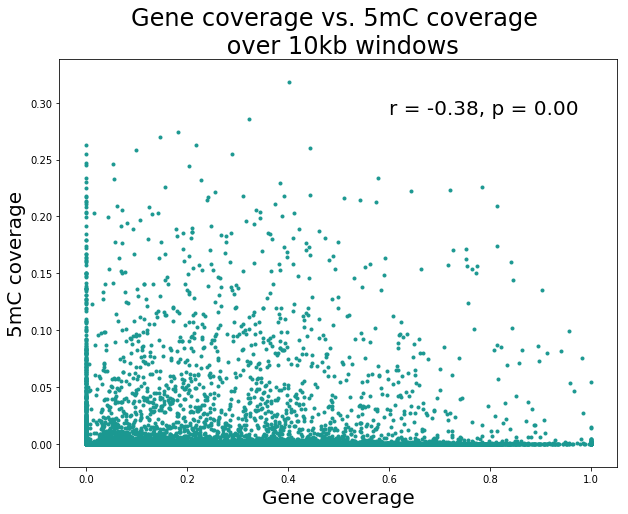

In [242]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.scatter(gene, m5c, marker='.', c='#1b9891')
plt.xlabel('Gene coverage', fontsize=20)
plt.ylabel('5mC coverage', fontsize=20)
plt.title("Gene coverage vs. 5mC coverage \n over 10kb windows", fontsize=24)
plt.text(0.6,0.29,'r = -0.38, p = 0.00', fontsize=20)
plt.show()

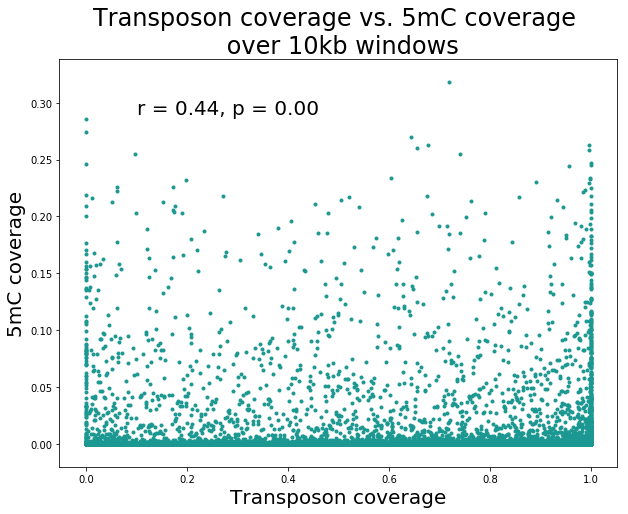

In [239]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.scatter(te, m5c, marker='.', c='#1b9891')
plt.xlabel('Transposon coverage', fontsize=20)
plt.ylabel('5mC coverage', fontsize=20)
plt.title("Transposon coverage vs. 5mC coverage \n over 10kb windows", fontsize=24)
plt.text(0.1,0.29,'r = 0.44, p = 0.00', fontsize=20)
plt.show()

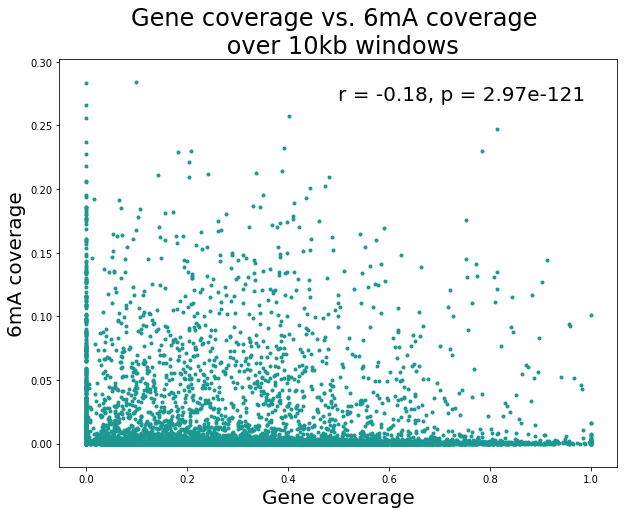

In [253]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.scatter(gene, m6a, marker='.', c='#1b9891')
plt.xlabel('Gene coverage', fontsize=20)
plt.ylabel('6mA coverage', fontsize=20)
plt.title("Gene coverage vs. 6mA coverage \n over 10kb windows", fontsize=24)
plt.text(0.5,0.27,'r = -0.18, p = 2.97e-121', fontsize=20)
plt.show()

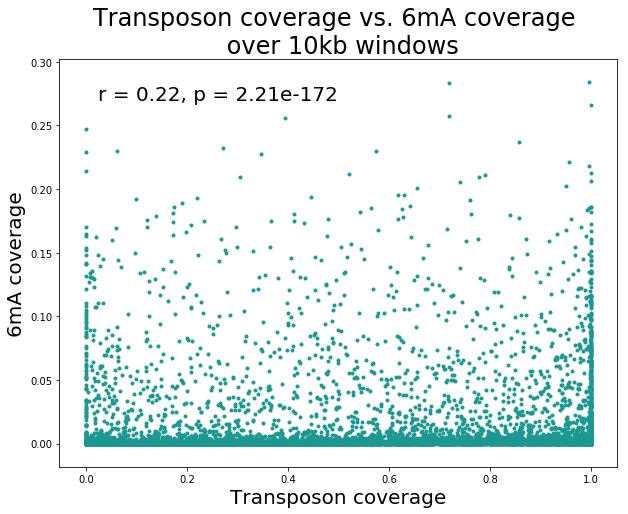

In [251]:
fig, ax = plt.subplots(figsize=(10, 7.5))

plt.scatter(te, m6a, marker='.', c='#1b9891')
plt.xlabel('Transposon coverage', fontsize=20)
plt.ylabel('6mA coverage', fontsize=20)
plt.title("Transposon coverage vs. 6mA coverage \n over 10kb windows", fontsize=24)
plt.text(0.023,0.27,'r = 0.22, p = 2.21e-172', fontsize=20)
plt.show()

In [2505]:
# save out the Spearman's rho values as a table
spearman_df = pd.DataFrame.from_dict(ug_spearman_dict, orient='index')
spearman_df.rename(columns={0: 'R', 1: 'p-value'}, inplace=True)
out_fn = os.path.join(DIRS['FIGURES'], 'expression', 'spearman_r_table.tsv')
spearman_df.to_csv(out_fn, header=True, sep = '\t')

In [ ]:
# 6mA: Spearman's rho between ranked methylated genes in df and ranked expressed genes in df

In [ ]:
# Ignore both_u_d files for now!
# For the both_u_d files:
# iterrows through df and if name == name:
# add the frac1 + frac2 and divide by 2
# append the average to a list
# make a new df of ... ok this is too hard I'll ask Ben on Monday

In [ ]:
# Make files ranking genes expressed in each life cycle stage from high to low expression

# Make a new file of the highly expressed genes for each life cycle stage
# Make a new file of the lowly expressed genes for each life cycle stage

# Make a file of genes that are highly expressed in all stages -> for loop that checks whether gene is in all "highly expressed" files


## <span style='color:#9ac615'> 8. Intersecting methylation with transposons expression files. <span/>

## <span style='color:#ffa347'> 10. Comparing methylated transposons and genes. <span/>

## <span style='color:#ff4f14'> 11. Expression of methylation machinery throughout Pst life cycle. <span/>

DNMT1/MASC2
query: XP_001833175.2, len = 1253

h_subject: Pst104E_20230, len = 1248

Score = 206 bits (523), Expect = 5e-54, Method: Compositional matrix adjust. Identities = 241/925 (26%), Positives = 372/925 (40%), Gaps = 178/925 (19%)

p_subject: Pst104E_04293, len = 1248

Score = 206 bits (523), Expect = 5e-54, Method: Compositional matrix adjust. Identities = 241/925 (26%), Positives = 372/925 (40%), Gaps = 178/925 (19%)

RAD8
query: XP_001831325.2, len = 2184

h_subject: Pst104E_28179, len = 2204

Score = 1158 bits (2996), Expect = 0.0, Method: Compositional matrix adjust. Identities = 643/1386 (46%), Positives = 837/1386 (60%), Gaps = 76/1386 (5%)

p_subject: Pst104E_12497, len = 1248

DNMT1/MASC2
- h_subject: Pst104E_20230   //   gene_model_hcontig_0009_24.226
- p_subject: Pst104E_04293   //   gene_model_pcontig_009.363
    
RAD8
- h_subject: Pst104E_28179   //   gene_model_hcontig_0052_06.60
- p_subject: Pst104E_12497   //   gene_model_pcontig_052.64


In [ ]:
# write this function later!!
def grep_gene_name()

In [168]:
# make dicts of BLAST results
blast_h = { 'DNMT1/MASC2' : 'gene_model_hcontig_0009_24.226', 'RAD8' : 'gene_model_hcontig_0052_06.60' }
blast_p = { 'DNMT1/MASC2' : 'gene_model_pcontig_009.363', 'RAD8' : 'gene_model_pcontig_052.64' }

In [169]:
# make rnaseq dict
rnaseq_df_dict = {}
for fn in glob.iglob('%s/*_gene_rpkm_average.tsv' % DIRS['MEAN_STD'], recursive=True):
    if len(fn) == 87:
        df = pd.read_csv(fn, header=0, sep='\t')
        rnaseq_df_dict[fn.split('/')[-1]] = df

In [180]:
rnaseq_fn_dict = {}
for fn in glob.iglob('%s/*_gene_rpkm_average.tsv' % DIRS['MEAN_STD'], recursive=True):
    if len(fn) == 87:
        rnaseq_fn_dict[fn.split('/')[-1]] = fn

In [181]:
rnaseq_fn_dict

{'Pst_104E_v13_h_gene_rpkm_average.tsv': '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_h_gene_rpkm_average.tsv',
 'Pst_104E_v13_p_gene_rpkm_average.tsv': '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_p_gene_rpkm_average.tsv'}

In [166]:
DIRS['MEAN_STD']

'/home/anjuni/analysis/rna_counts/average_and_stdev'

In [171]:
rnaseq_df_dict['Pst_104E_v13_h_gene_rpkm_average.tsv'].head()

,gene_ID,GS,HE,IT0,IT6,IT9,UG
0,gene_model_hcontig_0000_03.1,0.487427,0.000000,0.000000,0.000000,2.377196,0.384531
1,gene_model_hcontig_0000_03.2,0.577405,144.208849,0.000000,1016.181477,456.791691,0.446980
2,gene_model_hcontig_0000_03.3,564.783136,52.086774,24.713948,235.779282,239.133947,316.475087
3,gene_model_hcontig_0000_03.4,0.000000,0.167865,0.000000,0.115347,0.179739,0.000000
4,EVM prediction%2hcontig_0000_003.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [172]:
for rkey, rvalue in rnaseq_fn.items():
    df = pd.read_csv(rvalue, sep='\t', header = 0)

df.head()
type(df)

pandas.core.frame.DataFrame

In [173]:
def blast_exp_df(blast_dict, rnaseq_df):
    for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_

SyntaxError: invalid syntax (<ipython-input-173-bc07e9909af0>, line 3)

In [189]:
for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_fn.items():
            df = pd.read_csv(rvalue, sep='\t', header = 0)
            for index, row in df.iterrows():
                if bvalue == row['gene_ID']:
                    pprint.pprint(row)

gene_ID    gene_model_hcontig_0009_24.226
GS                                14.0442
HE                                 10.199
IT0                                     0
IT6                               8.27879
IT9                               13.4791
UG                                8.75372
Name: 5163, dtype: object
gene_ID    gene_model_hcontig_0052_06.60
GS                               25.5531
HE                               5.27593
IT0                              4.24689
IT6                              23.0232
IT9                              43.3039
UG                               23.2504
Name: 14740, dtype: object


In [2554]:
for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_fn.items():
            df = pd.read_csv(rvalue, sep='\t', header = 0)
            for index, row in df.iterrows():
                if bvalue == row['gene_ID']:
                    pprint.pprint(row)

gene_ID    gene_model_pcontig_009.363
GS                             12.535
HE                            9.15761
IT0                                 0
IT6                           7.68013
IT9                           12.3386
UG                            7.73364
Name: 5174, dtype: object
gene_ID    gene_model_pcontig_052.64
GS                           22.8899
HE                           4.73403
IT0                          3.78453
IT6                          21.4138
IT9                          39.8084
UG                           20.6473
Name: 15076, dtype: object


In [199]:
blast_dict = blast_h
rnaseq_fn = {}
rnaseq_fn['Pst_104E_v13_h_gene_rpkm_average.tsv'] = rnaseq_fn_dict['Pst_104E_v13_h_gene_rpkm_average.tsv']

In [ ]:
# getting stdev

In [194]:
rnaseq_fn_dict = {}
for fn in glob.iglob('%s/*_gene_rpkm_stdev.tsv' % DIRS['MEAN_STD'], recursive=True):
    if len(fn) == 85:
        rnaseq_fn_dict[fn.split('/')[-1]] = fn

In [195]:
rnaseq_fn_dict

{'Pst_104E_v13_h_gene_rpkm_stdev.tsv': '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_h_gene_rpkm_stdev.tsv',
 'Pst_104E_v13_p_gene_rpkm_stdev.tsv': '/home/anjuni/analysis/rna_counts/average_and_stdev/Pst_104E_v13_p_gene_rpkm_stdev.tsv'}

In [200]:
for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_fn.items():
            df = pd.read_csv(rvalue, sep='\t', header = 0)
            for index, row in df.iterrows():
                if bvalue == row['gene_ID']:
                    pprint.pprint(row)

gene_ID    gene_model_hcontig_0009_24.226
GS                               0.710032
HE                               0.244654
IT0                                     0
IT6                               1.12791
IT9                               1.75511
UG                                1.15206
Name: 5163, dtype: object
gene_ID    gene_model_hcontig_0052_06.60
GS                               2.11856
HE                              0.382341
IT0                              6.00601
IT6                              2.55504
IT9                              11.9945
UG                              0.954619
Name: 14740, dtype: object


In [201]:
blast_dict = blast_p
rnaseq_fn = {}
rnaseq_fn['Pst_104E_v13_p_gene_rpkm_average.tsv'] = rnaseq_fn_dict['Pst_104E_v13_p_gene_rpkm_average.tsv']

In [184]:
rnaseq_fn

{'Pst_104E_v13_h_gene_rpkm_average.tsv':                                    gene_ID          GS          HE        IT0  \
 0             gene_model_hcontig_0000_03.1    0.487427    0.000000   0.000000   
 1             gene_model_hcontig_0000_03.2    0.577405  144.208849   0.000000   
 2             gene_model_hcontig_0000_03.3  564.783136   52.086774  24.713948   
 3             gene_model_hcontig_0000_03.4    0.000000    0.167865   0.000000   
 4       EVM prediction%2hcontig_0000_003.5    0.000000    0.000000   0.000000   
 5       EVM prediction%2hcontig_0000_003.6    0.000000    0.000000   0.000000   
 6             gene_model_hcontig_0000_03.7   10.457924    0.176728   0.000000   
 7             gene_model_hcontig_0000_03.8    0.000000   31.659461   0.000000   
 8             gene_model_hcontig_0000_03.9    0.005005    0.000000   0.000000   
 9            gene_model_hcontig_0000_03.10    0.000000    0.000000   0.000000   
 10           gene_model_hcontig_0000_03.11    0.035380   

In [202]:
for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_fn.items():
            df = pd.read_csv(rvalue, sep='\t', header = 0)
            for index, row in df.iterrows():
                if bvalue == row['gene_ID']:
                    pprint.pprint(row)

gene_ID    gene_model_pcontig_009.363
GS                           0.626692
HE                           0.208539
IT0                                 0
IT6                           1.11119
IT9                            1.5958
UG                            1.02412
Name: 5174, dtype: object
gene_ID    gene_model_pcontig_052.64
GS                           1.90044
HE                           0.33067
IT0                          5.35214
IT6                          2.06825
IT9                          11.0626
UG                          0.833817
Name: 15076, dtype: object


In [218]:
# getting all values
rnaseq_fn_dict = {}
for fn in glob.iglob('%s/*_gene_repRpkmMatrix_featureCounts.tsv' % DIRS['TRIALS'], recursive=True):
    if len(fn) == 95:
        rnaseq_fn_dict[fn.split('/')[-1]] = fn

In [219]:
rnaseq_fn_dict

{'Pst_104E_v13_h_gene_repRpkmMatrix_featureCounts.tsv': '/home/anjuni/analysis/rna_counts/trials_tsv/Pst_104E_v13_h_gene_repRpkmMatrix_featureCounts.tsv',
 'Pst_104E_v13_p_gene_repRpkmMatrix_featureCounts.tsv': '/home/anjuni/analysis/rna_counts/trials_tsv/Pst_104E_v13_p_gene_repRpkmMatrix_featureCounts.tsv'}

In [220]:
blast_dict = blast_h
rnaseq_fn = {}
rnaseq_fn['Pst_104E_v13_h_gene_repRpkmMatrix_featureCounts.tsv'] = rnaseq_fn_dict['Pst_104E_v13_h_gene_repRpkmMatrix_featureCounts.tsv']

In [222]:
blast_dict = blast_p
rnaseq_fn = {}
rnaseq_fn['Pst_104E_v13_p_gene_repRpkmMatrix_featureCounts.tsv'] = rnaseq_fn_dict['Pst_104E_v13_p_gene_repRpkmMatrix_featureCounts.tsv']

In [223]:
for bkey, bvalue in blast_dict.items():
        for rkey, rvalue in rnaseq_fn.items():
            df = pd.read_csv(rvalue, sep='\t', header = 0)
            for index, row in df.iterrows():
                if bvalue == row['gene_ID']:
                    pprint.pprint(row)

gene_ID    gene_model_pcontig_009.363
GS_1                          13.4194
GS_2                          12.0437
GS_3                          12.1418
HE_1                          9.45151
HE_2                          9.03185
HE_3                          8.98946
IT0_1                               0
IT0_2                               0
IT0_3                               0
IT6_1                         8.02585
IT6_2                         8.83485
IT6_3                          6.1797
IT9_1                         10.5812
IT9_2                          11.991
IT9_3                         14.4435
UG_1                          8.34558
UG_2                          6.29084
UG_3                          8.56451
Name: 5174, dtype: object
gene_ID    gene_model_pcontig_052.64
GS_1                         24.0007
GS_2                          20.215
GS_3                         24.4539
HE_1                         4.28587
HE_2                         5.07378
HE_3                         4

In [ ]:
# pull out the gene names for these locus tags from the annotation files

# test for significant difference between alleles on both contigs

## <span style='color:#ff4f14'>  12. Data processing for tables and graphs. <span/>

In [ ]:
# Make cutoff files for Nanopolish and SMRTLink, for the table

# Saving out a csv file of cutoff vs. num_sites_file1, num_sites_file2, num_overlap_sites, %_overlap for each initial file
# Already done for tombo 6mA and all overlaps, need to do for NP, Tombo CpG and PB cutoff files
# The csv will be formatted in excel :)

# Ask Ben how to format headings properly

header_6mA = ['Cutoff', 'Nanopore', 'PacBio', 'Overlapping sites', 'Percentage Overlap']

header_5mC = ['Cutoff', 'Tombo', 'Nanopolish', 'Overlapping sites', 'Percentage Overlap']

for akey, avalue in dict_a.items():
    for bkey, bvalue in dict_b.items():
        linakey= []
        if akey == bkey:
            cutoff = akey[x:x]
            line.append(cutoff, avalue, bvalue)
            